In [9]:
import torch
import os
import sys
import pandas as pd
from tqdm.auto import tqdm
from torcheval.metrics.functional import r2_score
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Distances import Distances, Normalizer
from OrigamiTransform import OrigamiTransform
origami_transform = OrigamiTransform()
from Coordinates import Coordinates, coords_to_dists
from Distances import Distances
sys.path.insert(1,'../code/data_utils/')
from ConfigDataset import ConfigDataset
from EmbeddedRegions import EmbeddedRegions
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
num_beads=64
mean_dist_fp = '../data/mean_dists.pt'
mean_sq_dist_fp = '../data/squares.pt'
config_fp='../data/processed_data.hdf5'
embedding_dir = '../data/embeddings_64_after_transformer/'
#uncorrected_dists_fp = '../data/samples/origami_64_no_embed_reduction/eval_mode/unguided.pt'
#corrected_coords_fp = '../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt'
uncorrected_dists_fp = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan_uncorrected_combined.pt'
corrected_coords_fp = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan_corrected_combined.pt'
uncorrected_dists_dir = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/'
corrected_coords_dir = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/corrected/'
save_folder = './distance_statistics_guided/'

Load Tan configs

In [3]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=num_beads,
    remove_diagonal=True,
    batch_size=0,
    normalize_distances=False, #True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None, #[str(chrom)],#training_chroms,
    replicates=None,
    shuffle=False,#True,
    allow_overlap=False,#True, # To avoid bias 
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)
er_index = pd.read_pickle(embedding_dir + '/rosetta_stone.pkl')

tan_coords = []
idx = torch.from_numpy(config_ds.start_indices)
for _ in range(num_beads):
    tan_coords.append(config_ds.coords[idx])
    idx+=1
tan_coords = torch.stack(tan_coords,dim=-2)
tan_coords = torch.cat(
    [
        tan_coords[...,:3], # Maternal chromosomes
        tan_coords[...,3:], # Paternal chromosomes
    ],
    dim=0
)
tan_coords = Coordinates(tan_coords)
tan_dists = tan_coords[:25000].distances
i = 25000
while i < len(tan_coords):
    j = min(i+25000,len(tan_coords))
    tan_dists = tan_dists.append(tan_coords[i:j].distances)
    i = j
del tan_coords, config_ds, er_index

Load generated data data. Only taking 100 conformations from each file (200 per region) due to memory constraints

In [4]:
#normalizer = Normalizer(mean_dist_fp=mean_dist_fp,mean_sq_dist_fp=mean_sq_dist_fp)
def load_dists(fp):
    #data = torch.load(fp)
    #return Distances(origami_transform.inverse(data,2*data.shape[-2]).squeeze()).unnormalize_(normalizer)
    return Distances(torch.load(fp)).unfold()

In [6]:
if os.path.exists(uncorrected_dists_fp):
    uncorrected = Distances(torch.load(uncorrected_dists_fp)).unfold()
else:
    uncorrected = [Distances(torch.load(uncorrected_dists_dir + fp))[:100,...].unfold().unnormalize() for fp in os.listdir(uncorrected_dists_dir) if 'sample_' in fp]
    uncorrected = uncorrected[0].append(uncorrected[1:])
    torch.save(uncorrected.fold().values,uncorrected_dists_fp)

if os.path.exists(corrected_coords_fp):
    corrected = Coordinates(corrected_coords_fp)
else:
    corrected = [Coordinates(corrected_coords_dir + fp)[:100,...] for fp in os.listdir(corrected_coords_dir) if 'sample_' in fp]
    corrected = corrected[0].append(corrected[1:])
    torch.save(corrected.values,corrected_coords_fp)
corrected = Distances(coords_to_dists(corrected.values,use_cuda=False)) # required with current implementation due to memory constraints on GPU

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.22 GiB (GPU 0; 31.74 GiB total capacity; 16.99 GiB already allocated; 11.90 GiB free; 17.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Ensure the save folder exists

In [11]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

## Main Text Figures

#### Distance Histograms

In [12]:
def compare_dist(sep=1,corrected=corrected,tan=tan_dists,fig=None,ax=None,nbins=100,**kwargs):

    assert sep > 0
    
    n = corrected.shape[-1]
    
    c = corrected.values[...,range(sep,n),range(n-sep)].flatten() * 100 # 100 to convert to nm
    t = tan.values[...,range(sep,n),range(n-sep)].flatten() * 100

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if 'bins' in kwargs:
        bins = kwargs.pop('bins')
    else:
        minn = 0#min(c[c.isfinite()].min(),t[t.isfinite()].min())
        maxx = max(c[c.isfinite()].max(),t[t.isfinite()].max())
        delta = (maxx-minn)/nbins
        bins = torch.arange(minn,maxx+delta,delta)
    
    c = c.cpu().numpy()
    t = t.cpu().numpy()
    
    ax.hist(c,alpha=0.5,label='ChromoGen',density=True,bins=bins,edgecolor='none',**kwargs)
    ax.hist(t,alpha=0.5,label='Dip-C',density=True,bins=bins,edgecolor='none',**kwargs)

    ax.set_xlabel('Distance (nm)')# (Bond Lengths)')
    ax.set_ylabel('Probability density')
    title = 'Euclidean distance distribution for monomers separated by:\n'
    title+= f'{sep} bonds' if sep != 1 else f'{sep} bond'
    ax.set_title(title)

    #ax.set_yticks(ax.get_ylim())
    
    ax.set_xlim([bins[0],bins[-1]])
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.legend(framealpha=0,loc='upper right')#,fontsize='small')

    return fig, ax
    

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'E', 'G', 'P', 'a', 'b', 'c', 'colon', 'd', 'e', 'f', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 26, 29, 38, 39, 40, 42, 51, 68, 69, 70, 71, 72, 73, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 41 glyphs after
INFO:fontTools.subset:

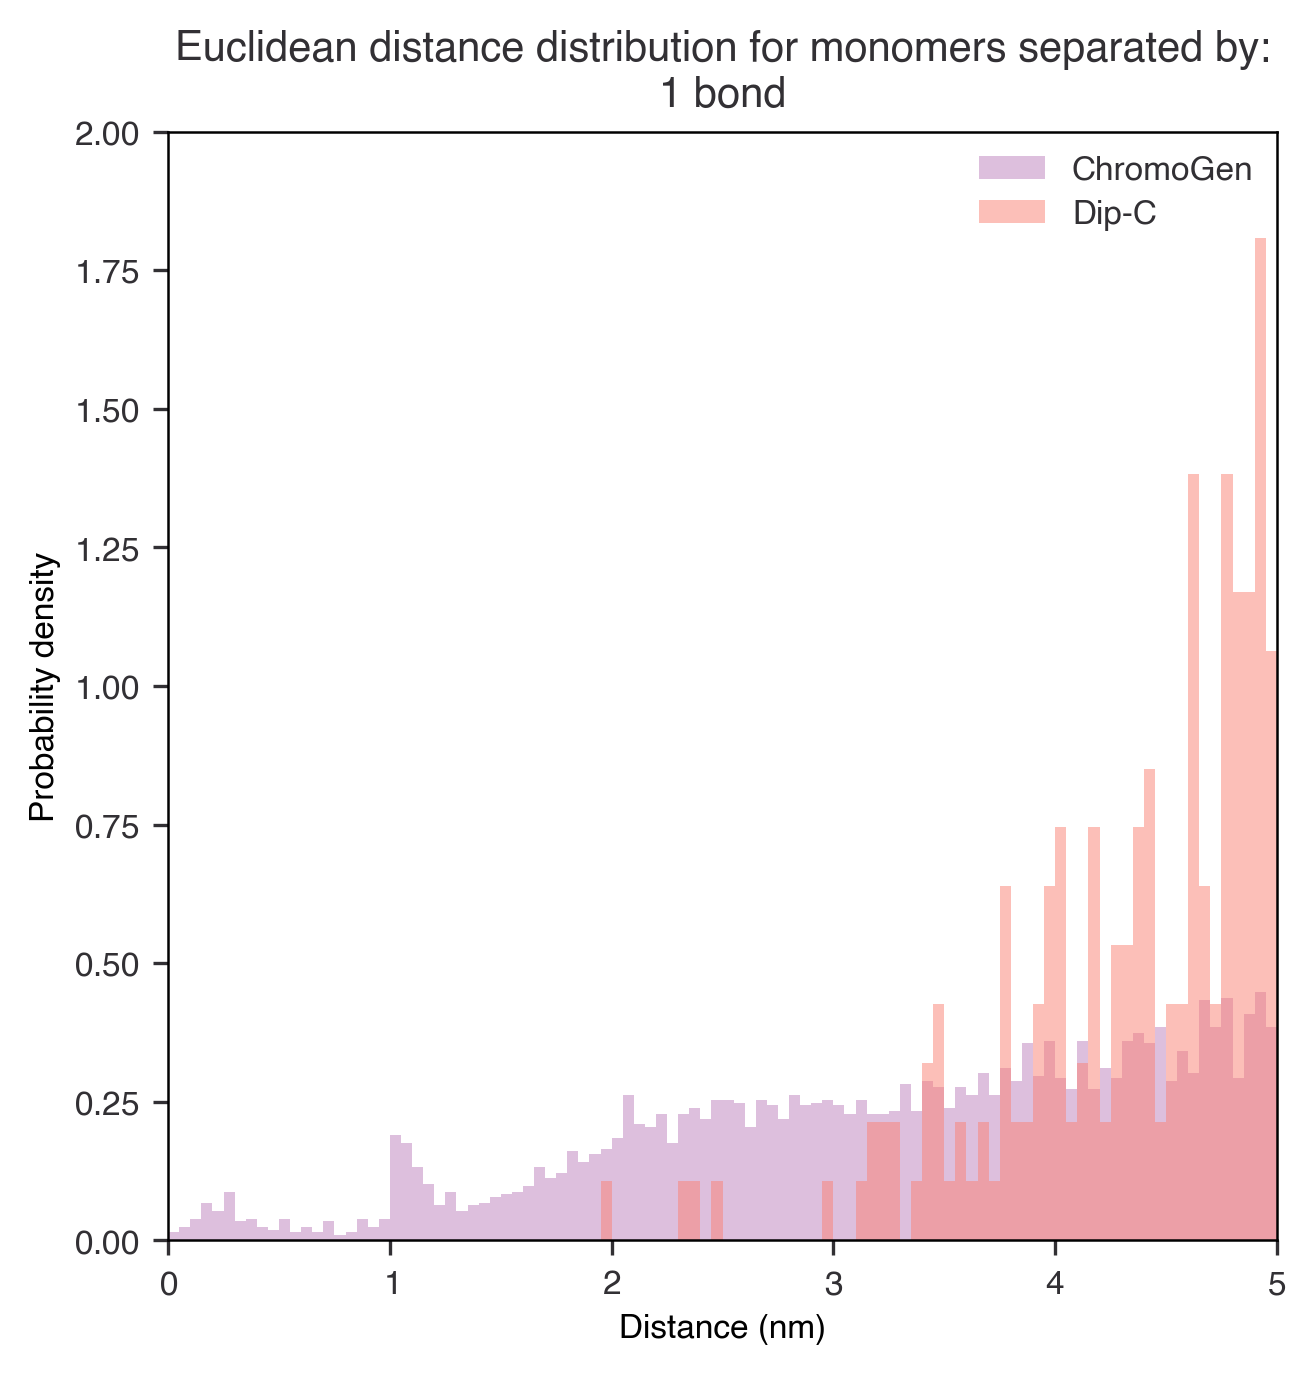

In [13]:
fig,_ = compare_dist(1,bins=torch.arange(0,5.04,.05))
fig.savefig(save_folder+'dist_hist_1.pdf',bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 40 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'E', 'G', 'P', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 29, 38, 39, 40, 42, 51, 68, 69, 70, 71, 72, 73, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 42 glyphs after
INFO:fontTo

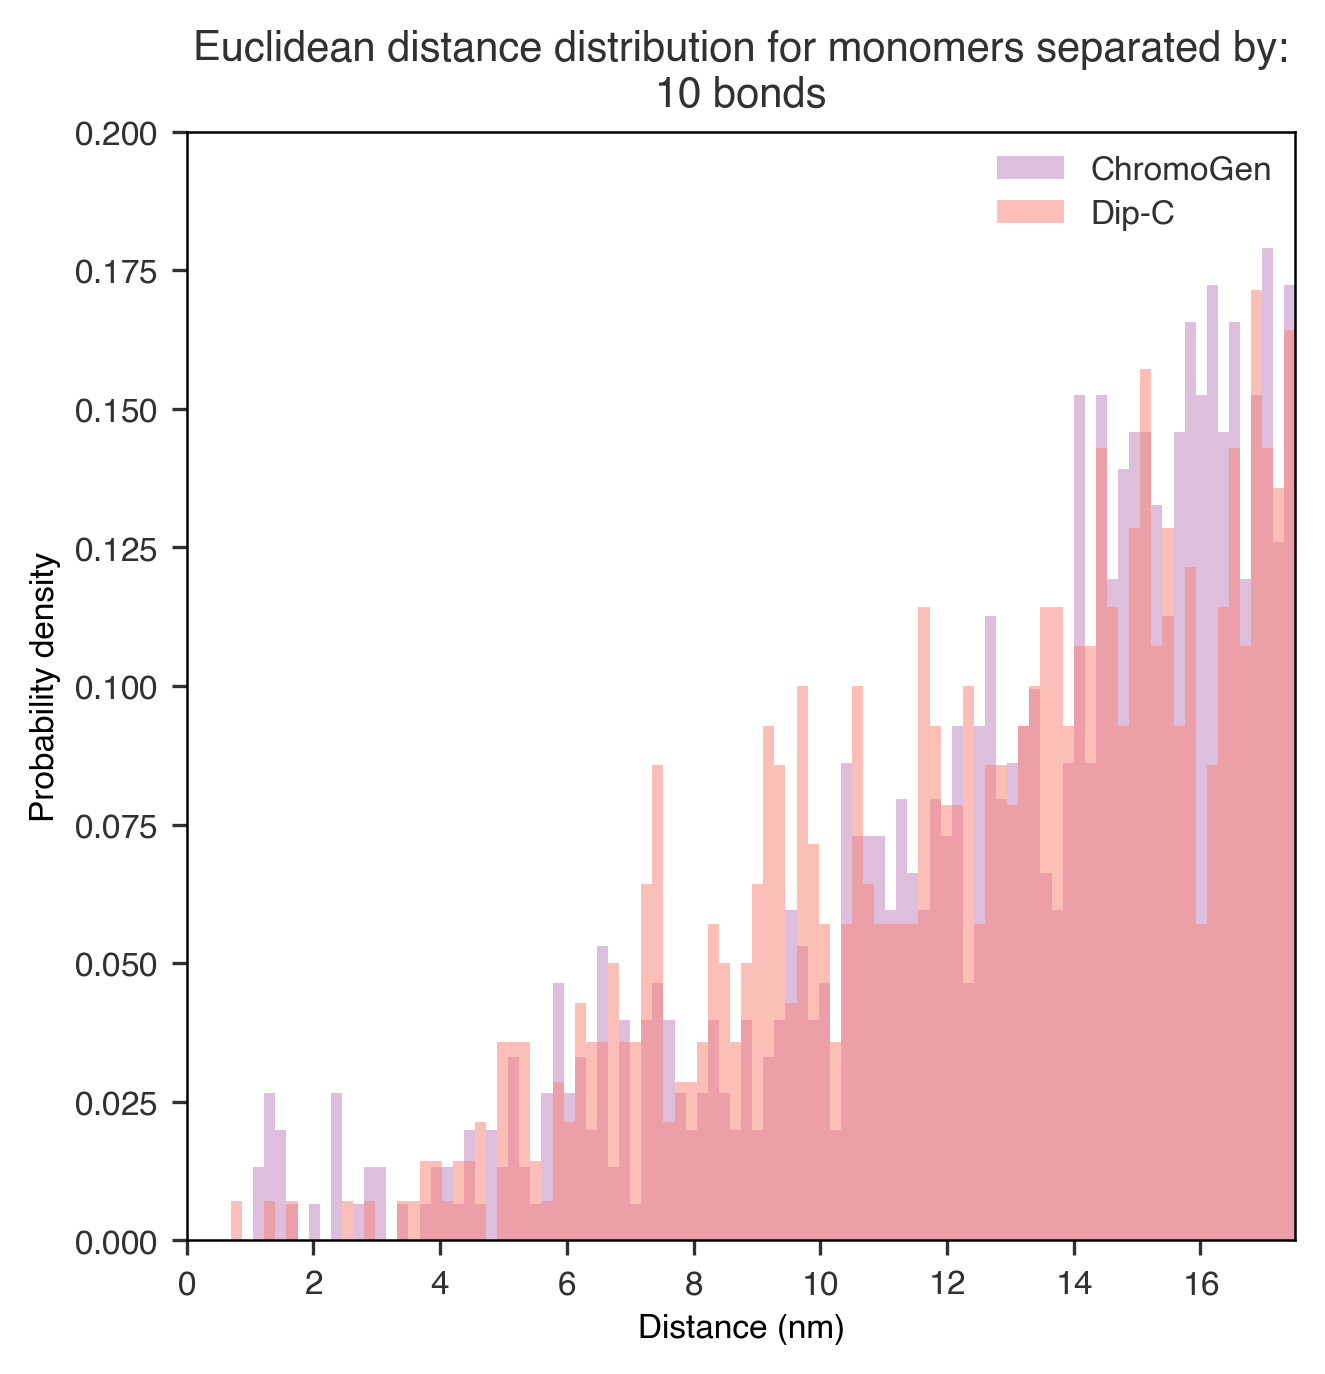

In [14]:
fig,_ = compare_dist(10,bins=torch.arange(0,17.51,.175))
fig.savefig(save_folder+'dist_hist_10.pdf',bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'E', 'G', 'P', 'a', 'b', 'c', 'colon', 'd', 'e', 'f', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 29, 38, 39, 40, 42, 51, 68, 69, 70, 71, 72, 73, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 40 glyphs after
INFO:fontTools.subset:Glyph names: 

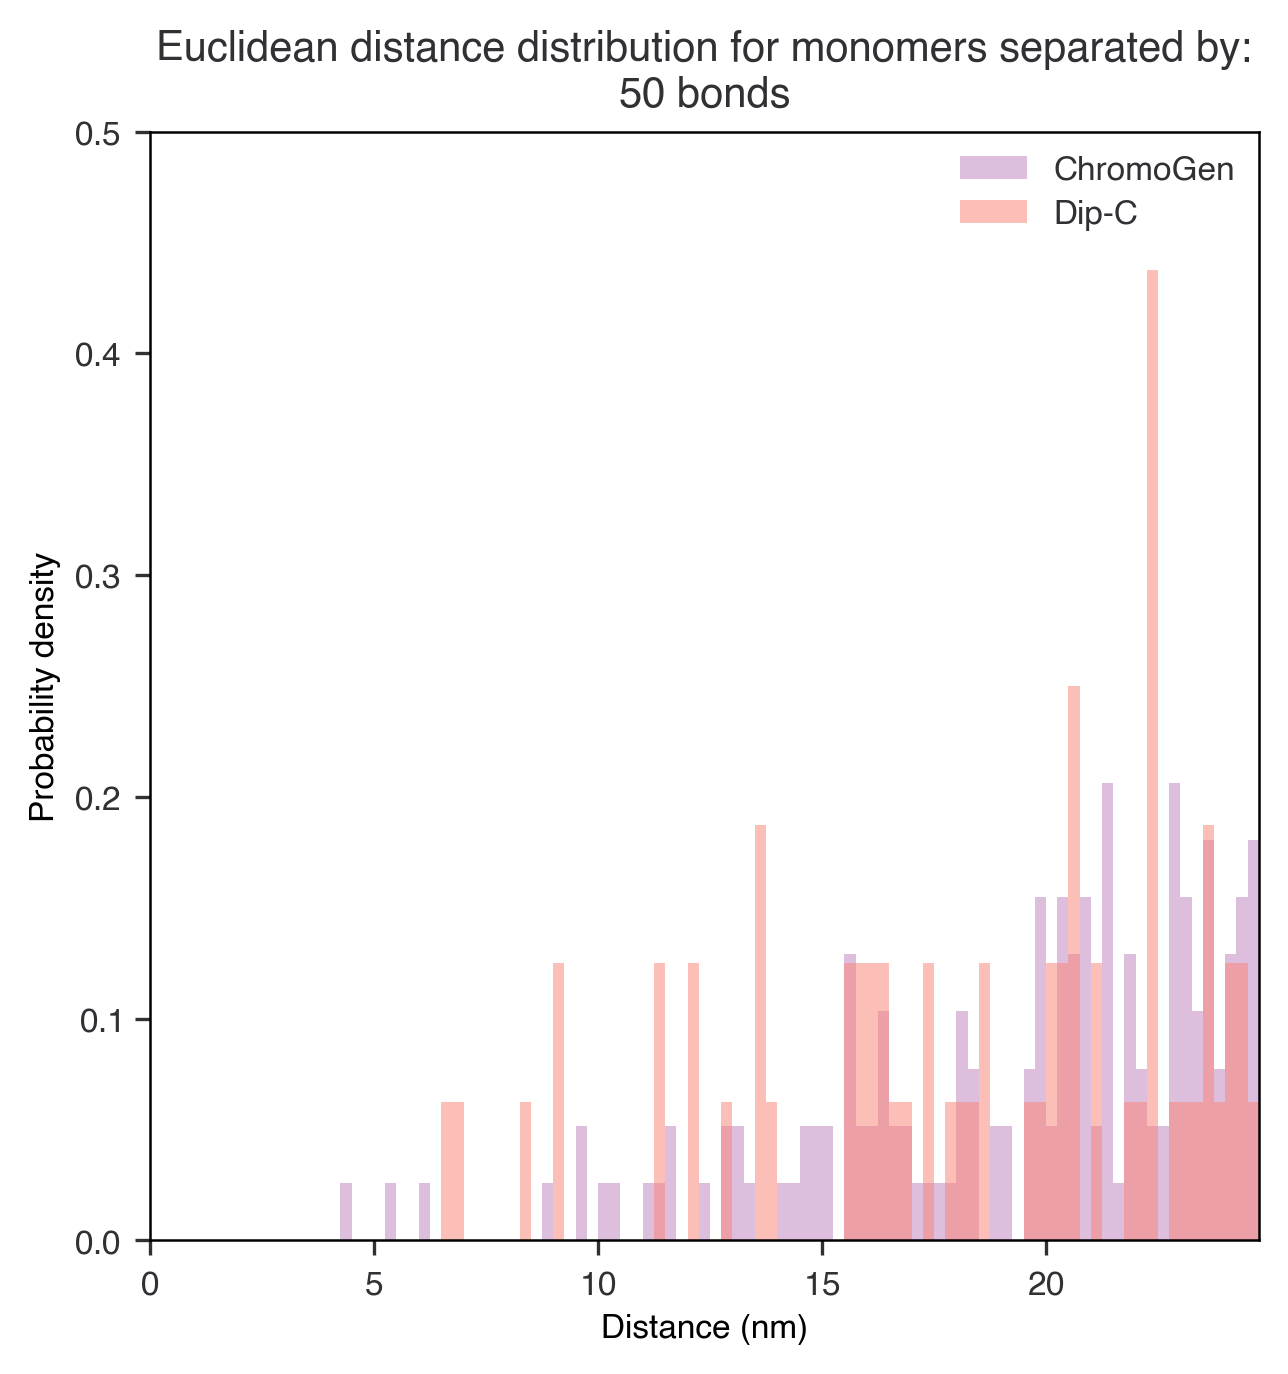

In [15]:
fig,_ = compare_dist(50,bins=torch.arange(0,25,.25))
fig.savefig(save_folder+'dist_hist_50.pdf',bbox_inches='tight')

#### Distance Correlation Maps

In [16]:
def correlation_compare(contact,corrected_dists=corrected,tan_dists=tan_dists):

    n = corrected_dists.shape[-1]
    bead_i,bead_j = contact

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    i,j = torch.triu_indices(n,n,1)
    correlations = torch.empty_like(corrected_dists.values[0,...].squeeze())
    corr_ref = corrected_dists.values[...,bead_i,bead_j].double().to(device).flatten()
    tan_ref = tan_dists.values[...,bead_i,bead_j].double().to(device).flatten()
    for bead_i1 in range(n-1):
        for bead_j1 in range(bead_i1+1,n):
            correlations[bead_i1,bead_j1] = torch.corrcoef(
                torch.stack(
                    [
                        tan_ref,
                        tan_dists.values[...,bead_i1,bead_j1].double().to(device).flatten()
                    ],
                    dim = 0
                )
            )[0,1]

            correlations[bead_j1,bead_i1] = torch.corrcoef(
                torch.stack(
                    [
                        corr_ref, 
                        corrected_dists.values[...,bead_i1,bead_j1].double().to(device).flatten()
                    ],
                    dim = 0
                )
            )[0,1]#.to(dtype=correlations.dtype,device=correlations.device)

    i = torch.arange(correlations.shape[-1])
    correlations[i,i] = torch.nan
            
    return correlations

from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_correlations(center_contact=(25,39),fig=None,ax=None):
    
    correlations = correlation_compare(center_contact)

    if fig is None or ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    im = ax.matshow(correlations.cpu().numpy(),cmap='magma')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cbar = fig.colorbar(im,cax=cax,label='$\\rho$',orientation='horizontal')#,ticks=cbar_ticks)
    
    #cbar.set_label('Pearson Correlation Coefficient')
    #ax.set_xlabel('Genomic Bin Index')
    #ax.set_ylabel('Genomic Bin Index')
    #cbar.set_label('$\\rho$')
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.set_title(f'Correlation between the distance separating\nmonomers {center_contact[0]} and {center_contact[1]} and the distances\nseparating all other interaction pairs')

    n = ax.get_xlim()[-1]
    ax.text(4,.005*n,'Dip-C Dataset',horizontalalignment='left',verticalalignment='top',
            color='white')
            #color='black'),path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    ax.text(n-4,.995*n-1,'ChromoGen Conformations',horizontalalignment='right',verticalalignment='baseline',
            color='white')
            #color='black'),path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    
    return fig, ax, im, cbar


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 38, 39, 42, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D',

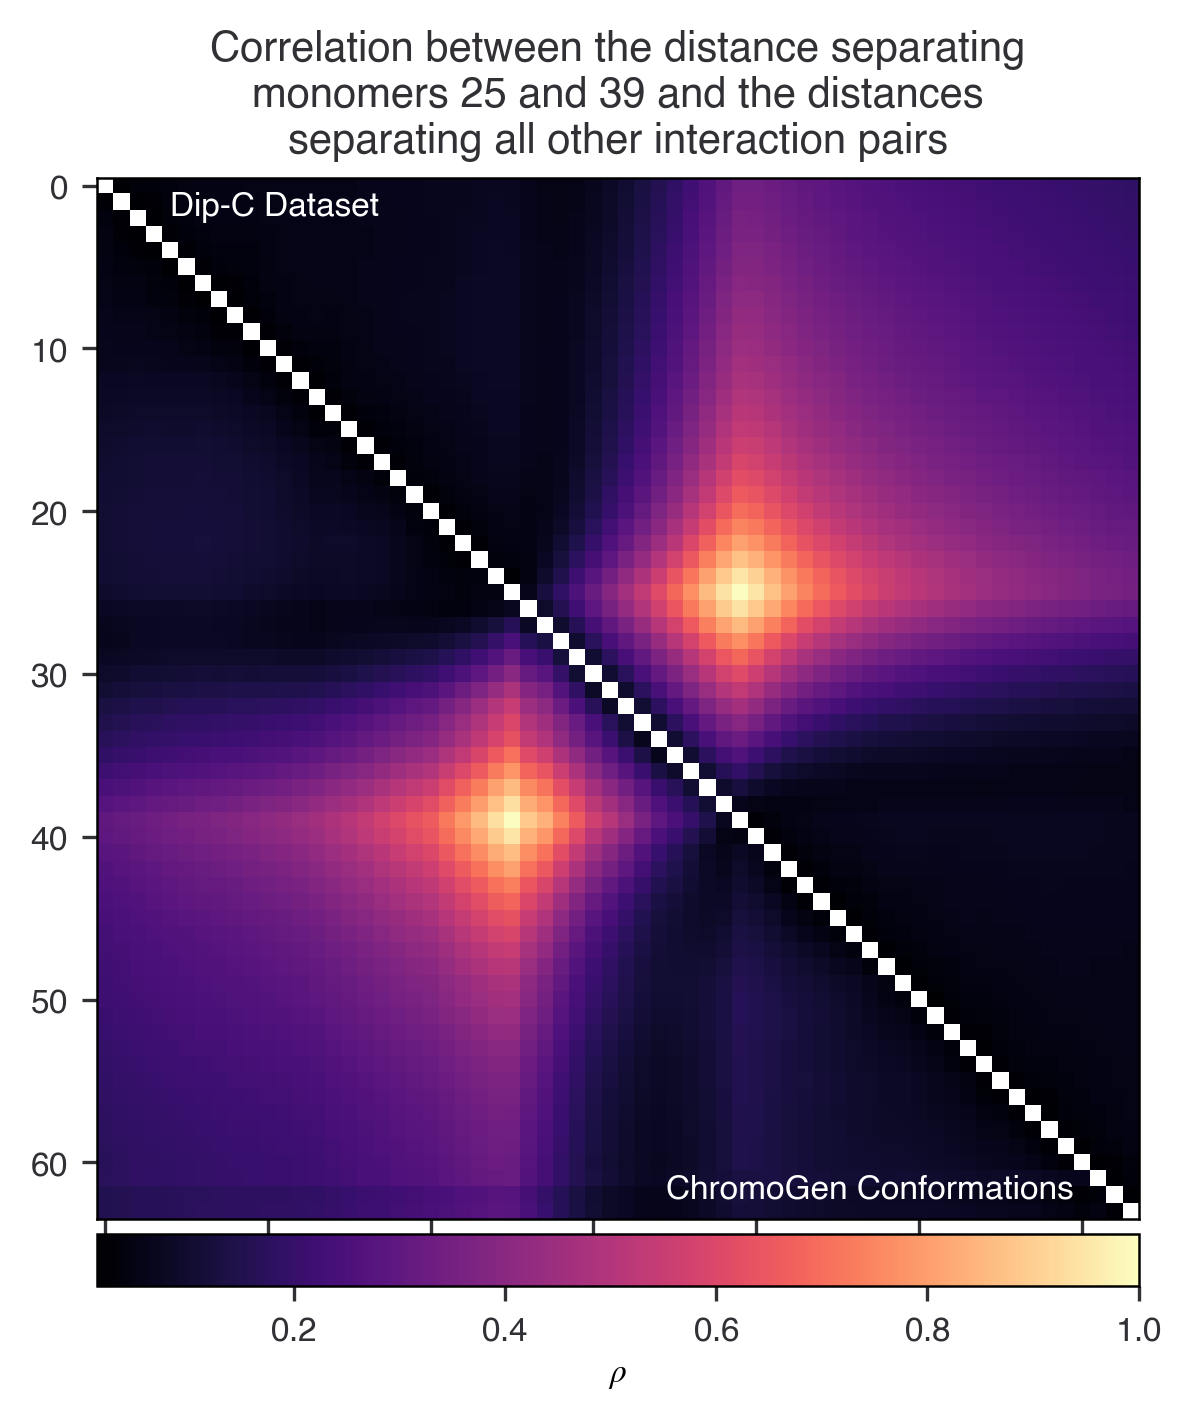

In [17]:
fig,*_=plot_correlations(center_contact=(25,39))
fig.savefig(save_folder+'dist_corr_25_39.pdf',bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 38, 39, 42, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 37 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'a', '

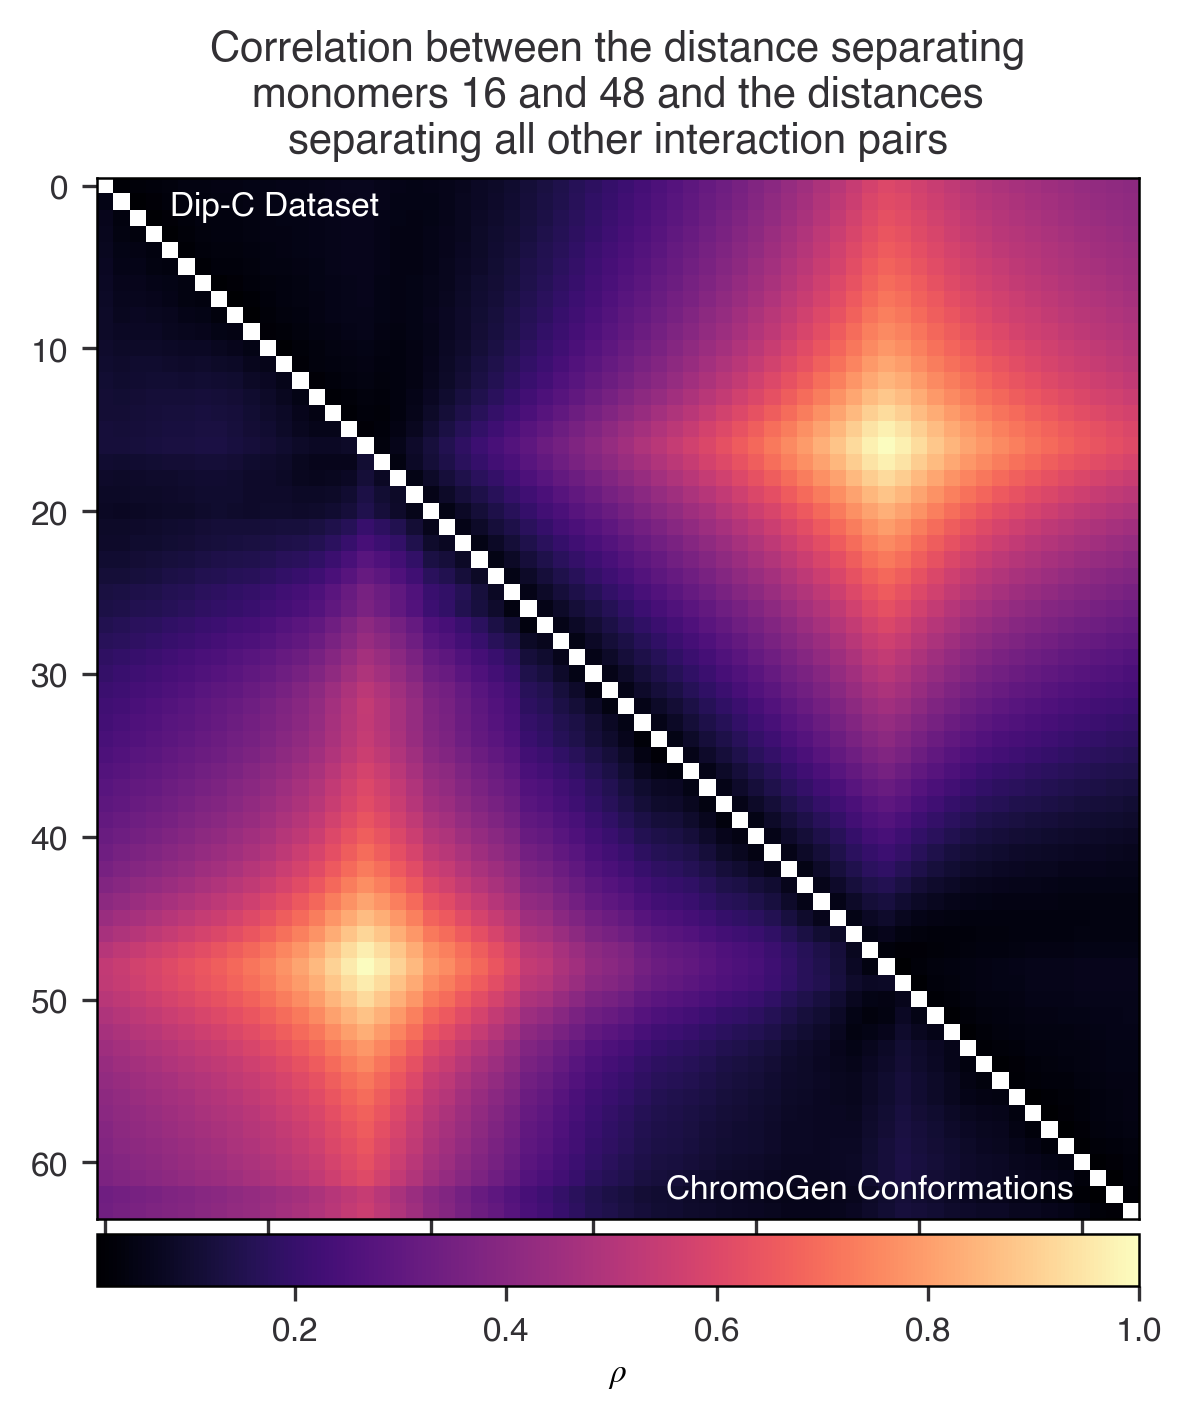

In [18]:
fig,*_=plot_correlations((16,48))
fig.savefig(save_folder+'dist_corr_16_48.pdf',bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 38, 39, 42, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 90]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D',

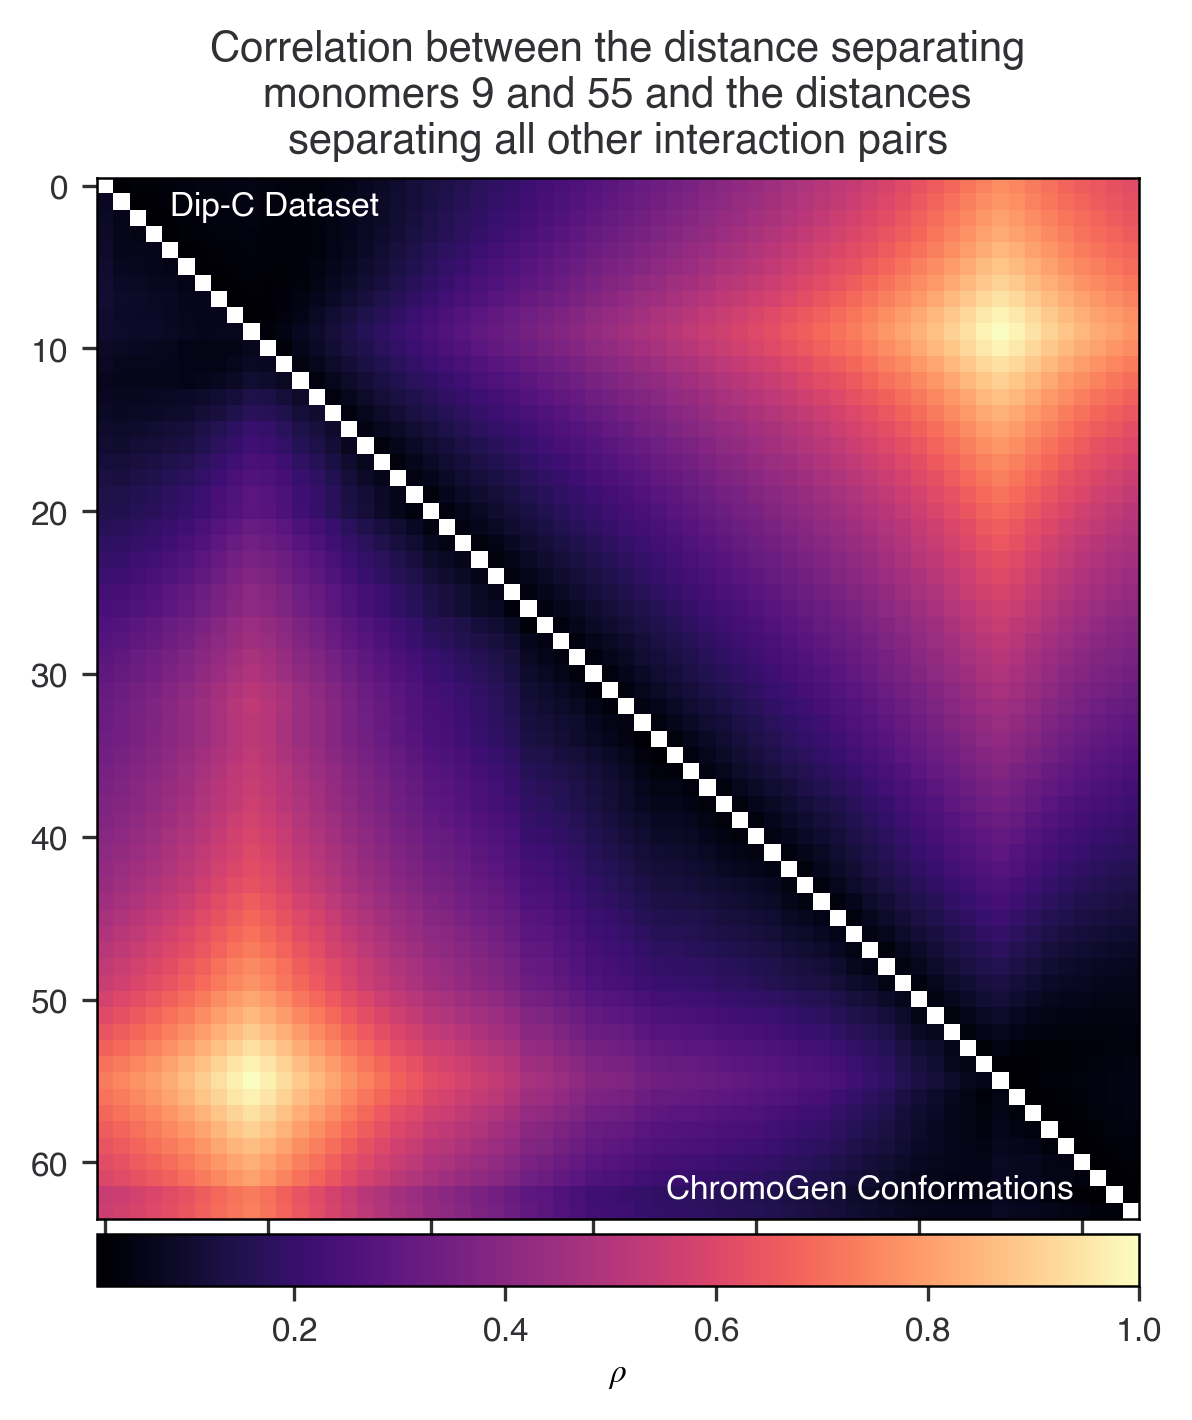

In [19]:
fig,*_=plot_correlations((9,55))
fig.savefig(save_folder+'dist_corr_9_55.pdf',bbox_inches='tight')

#### Plot them all together

Get some wide-ranging statistics

In [20]:
'''
def get_KL_div(gen_configs,tan_configs,separation,num_bins=100):

    # Collect the distances between beads separated by the specified separation
    n = gen_configs.num_beads
    s = separation
    gen_dists = gen_configs.distances.values[:,range(n-s),range(s,n)]
    tan_dists = tan_configs.distances.values[:,range(n-s),range(s,n)]

    # Choose the bins
    maxx = tan_dists.max()#max(gen_dists.max(),tan_dists.max())
    delta = maxx/num_bins
    bins = torch.arange(0,maxx+delta/2,delta)

    # Bin the data
    gen_probs = torch.histogram(gen_dists,bins,density=True).hist
    tan_probs = torch.histogram(tan_dists,bins,density=True).hist

    # Avoid NaN values
    idx = torch.where( (gen_probs!=0) & (tan_probs!=0) )[0]
    gen_probs = gen_probs[idx]
    tan_probs = tan_probs[idx]

    # Compute the KL-divergence with expectation probabilities from tan
    return (tan_probs * (tan_probs.log() - gen_probs.log())).sum()
'''
    
def get_KL_div(gen_configs,tan_configs,separation,num_bins=None):#100):

    # Collect the distances between beads separated by the specified separation
    n = gen_configs.num_beads
    s = separation
    gen_dists = gen_configs.distances.values[:,range(n-s),range(s,n)]
    tan_dists = tan_configs.distances.values[:,range(n-s),range(s,n)]

    # Determine number of bins to use
    if num_bins is None:
        n = min( gen_dists.numel(), tan_dists.numel() )
        num_bins = int( 2 * ( n )**(1/3) )
        # from rice, per https://stats.stackexchange.com/questions/510699/discrete-kl-divergence-with-decreasing-bin-width
    
    # Choose the bins
    maxx = tan_dists.max()#max(gen_dists.max(),tan_dists.max())
    delta = maxx/num_bins
    bins = torch.arange(0,maxx+delta/2,delta)

    # Bin the data
    gen_probs = torch.histogram(gen_dists,bins).hist#,density=True).hist
    tan_probs = torch.histogram(tan_dists,bins).hist#,density=True).hist

    # Normalize 
    gen_probs/= gen_probs.sum()
    tan_probs/= tan_probs.sum()
    
    # Avoid NaN values
    idx = torch.where( (gen_probs!=0) & (tan_probs!=0) )[0]
    gen_probs = gen_probs[idx]
    tan_probs = tan_probs[idx]

    # Compute the KL-divergence with expectation probabilities from tan
    #return (tan_probs * (tan_probs.log() - gen_probs.log())).sum()
    return (gen_probs * (gen_probs.log() - tan_probs.log())).sum() # using ln here reports units of nats
    
    
    

In [21]:
KL_divs = torch.tensor([get_KL_div(corrected,tan_dists.float_(),separation) for separation in range(1,64)])

#n = min( len(corrected), len(tan_dists) )
#nBins = 2 * ( n )**(1/3) # from rice, per https://stats.stackexchange.com/questions/510699/discrete-kl-divergence-with-decreasing-bin-width
#KL_divs2 = torch.tensor([get_KL_div(corrected,tan_dists.float_(),separation,num_bins=nBins) for separation in range(1,64)])
#plt.plot(KL_divs)
#plt.plot(KL_divs2)

In [22]:
f='./support/correlation_statistics.pt'
if os.path.exists(f):
    corr_r2 = torch.load(f)['corr_r2']
else:
    ii,jj = torch.triu_indices(64,64,1)
    corrs_tan = []
    corrs_gen = []
    n=0
    for i in range(0,64,10):
        for j in range(i+1,64):
            n+=1
    with tqdm(total=n,initial=0) as pbar:
        for i in range(0,64,10):
            for j in range(i+1,64):
                correlations = correlation_compare((i,j))
                corrs_tan.append(correlations[ii,jj])
                corrs_gen.append(correlations[jj,ii])
                pbar.update(1)
    corr_r2 = r2_score(torch.stack(corrs_gen,dim=0),torch.stack(corrs_tan,dim=0),multioutput='raw_values')
    torch.save(
        {
            'corrs_tan':corrs_tan,
            'corrs_gen':corrs_gen,
            'corr_r2':corr_r2
        },
        './support/correlation_statistics.pt'
    )

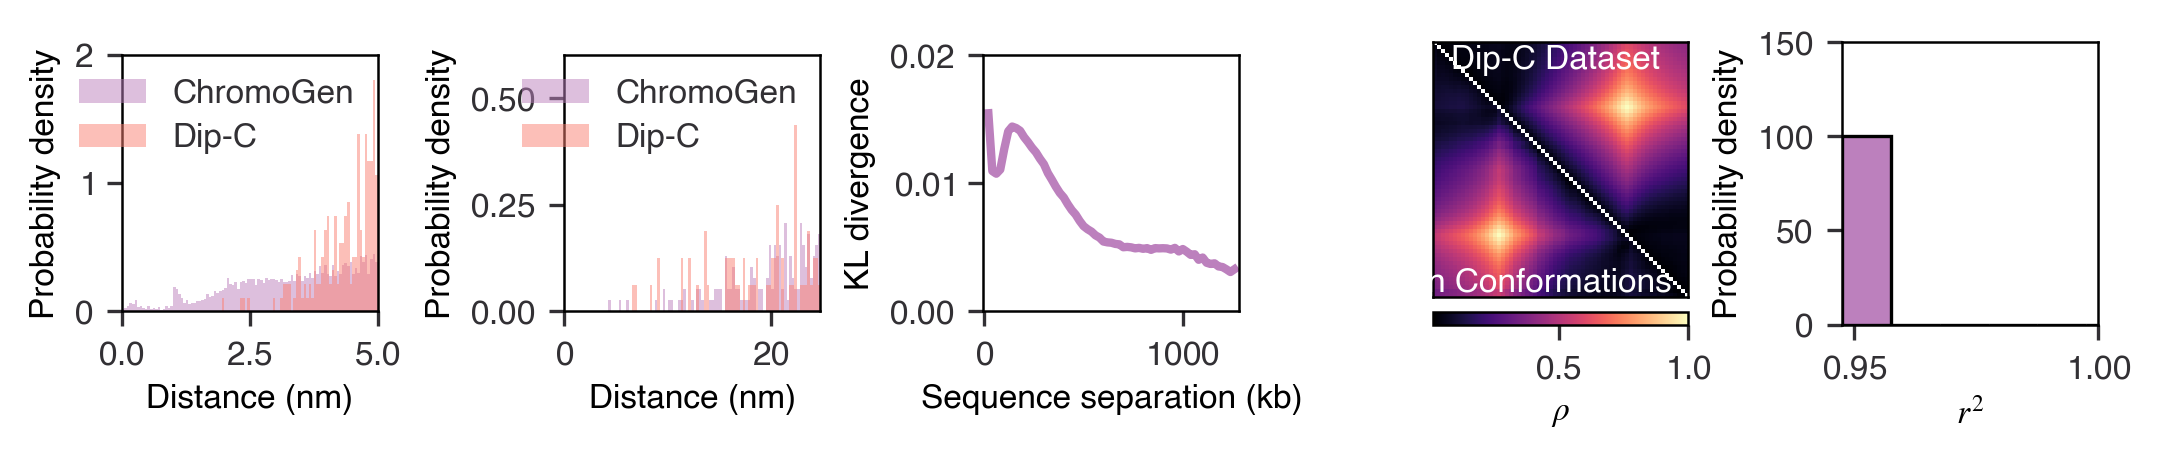

In [23]:
fig,axes = plt.subplots(nrows=1,ncols=5,layout='constrained',figsize=(7.08661,7.08661/5))

# Distance histograms
compare_dist(1,bins=torch.arange(0,5.04,.05),fig=fig,ax=axes[0])
compare_dist(50,bins=torch.arange(0,25,.25),fig=fig,ax=axes[1])

# Distance KL divergence plot
ax = axes[2]
ax.plot(torch.arange(1,64)*20,KL_divs)
#ax.set_title('Agreement between scPredict and Dip-C distances')
ax.set_xlabel('Sequence separation (kb)')
ax.set_ylabel('KL divergence')
ax.set_xlim([-5,1285])
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.set_aspect( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )

# Correlation figure
ax = axes[3]
plot_correlations((16,48),fig=fig,ax=ax)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xlabel('Genomic index')
#ax.set_ylabel('Genomic index')

# R-squared values for all correlations
ax = axes[-1]
ax.hist(corr_r2.cpu().flatten().numpy(),bins=100,density=True)
ax.set_xlabel('$r^2$')
ax.set_ylabel('Probability density')
#ax.set_title('$r^2$ between correlation plots')
ax.set_xlim([corr_r2.min(),1])

for ax in axes:
    ax.set_title('')


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'G', 'K', 'L', 'M', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 36, 38, 39, 42, 46, 47, 48, 51, 54, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92]
INFO:fontTools.subset

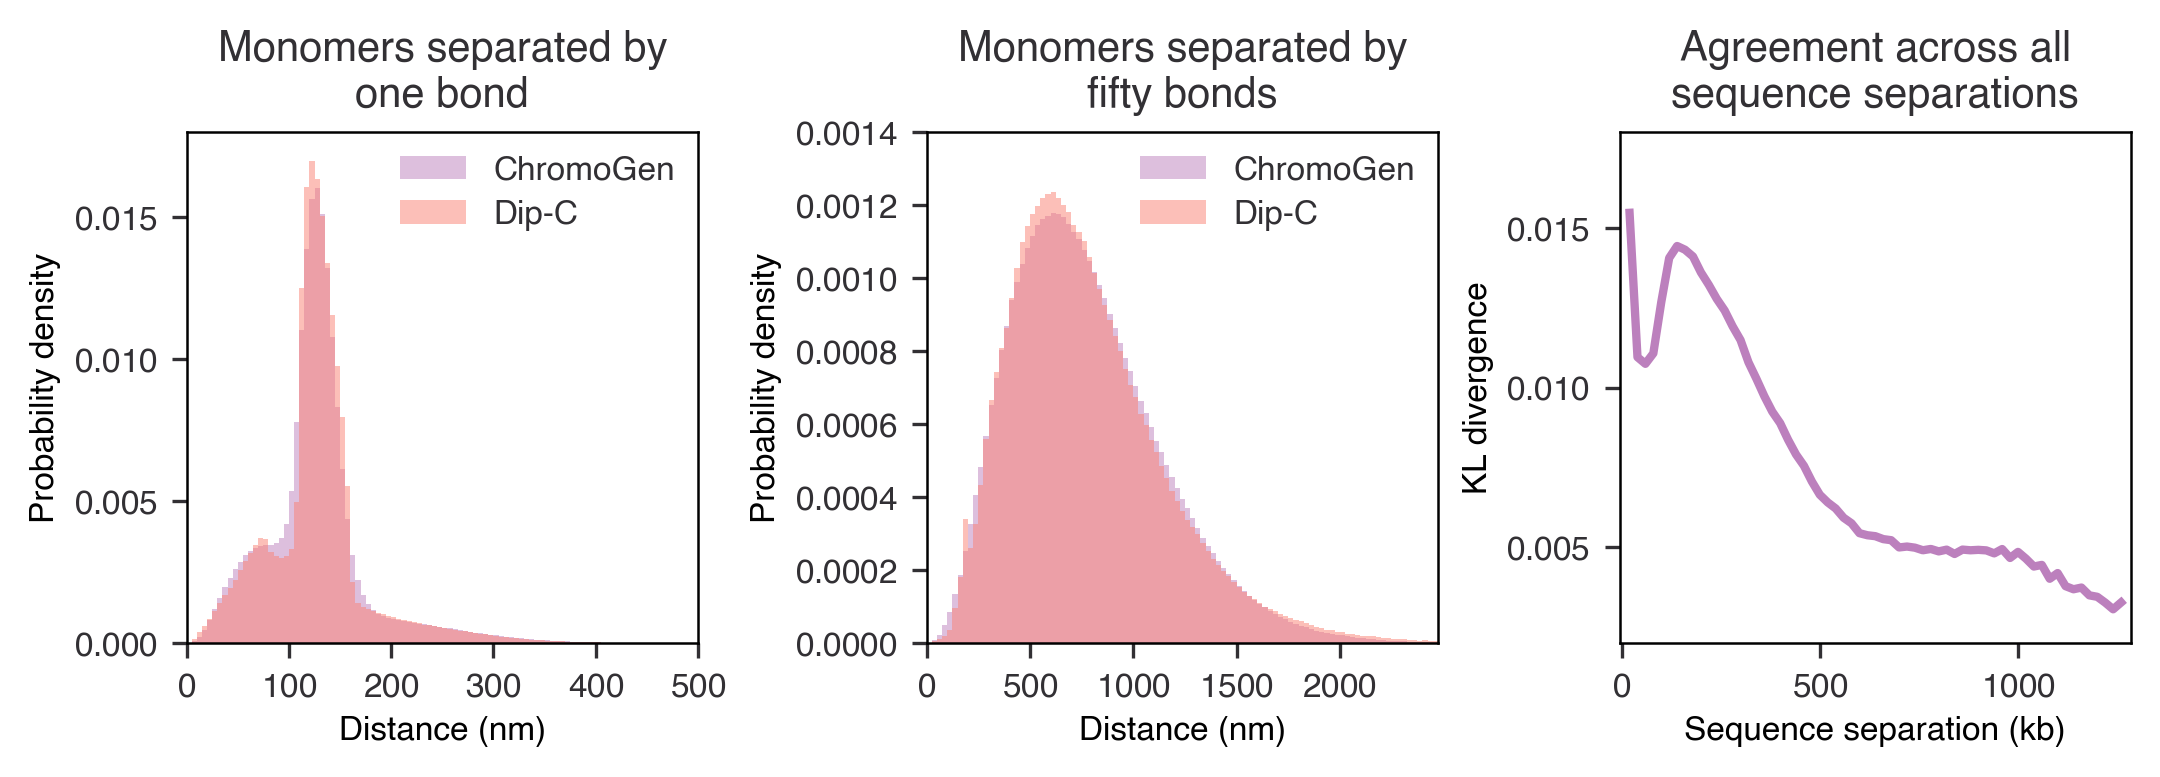

In [24]:
fig,axes = plt.subplots(nrows=1,ncols=3,layout='constrained',figsize=(7.08661,6.69291/2.5))

# Distance histograms
#compare_dist(1,bins=torch.arange(0,5.04,.05),fig=fig,ax=axes[0])
#compare_dist(50,bins=torch.arange(0,25,.25),fig=fig,ax=axes[1])
compare_dist(1,bins=torch.arange(0,504,5.),fig=fig,ax=axes[0])
axes[0].set_title('Monomers separated by\none bond')
compare_dist(50,bins=torch.arange(0,2500,25),fig=fig,ax=axes[1])
axes[1].set_title('Monomers separated by\nfifty bonds')

# Distance KL divergence plot
ax = axes[2]
ax.plot(torch.arange(1,64)*20,KL_divs)
#ax.set_title('Agreement between scPredict and Dip-C distances')
ax.set_xlabel('Sequence separation (kb)')
ax.set_ylabel('KL divergence')
ax.set_xlim([-5,1285])
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.set_aspect( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )
ax.set_title('Agreement across all\nsequence separations')

fig.savefig(save_folder + 'distance_stats.pdf',transparent=True)

#### $R_g$, minimum RMSD

In [25]:
def compute_rg(coords):
    return ( (coords.values - coords.values.mean(-2,keepdim=True)).square().sum((-2,-1)) / coords.num_beads).sqrt()

''' # Calculation performed elsewhere. See Figures/support/compute_minimum_rmsd.py -> combine_rmsd_mins.py
def compute_rmsd(coords,reference):
    aligned_coords = coords.trajectory.clone().superpose(reference)
    return aligned_coords.rmsd(reference)

from tqdm.auto import tqdm
def minimum_rmsds(coords,references):

    min_rmsds = None
    for reference in tqdm(references):
        if min_rmsds is None:
            min_rmsds = compute_rmsd(coords,reference)

        else:
            min_rmsds = torch.min( min_rmsds, compute_rmsd(coords,reference) )

    return min_rmsds
'''
    

' # Calculation performed elsewhere. See Figures/support/compute_minimum_rmsd.py -> combine_rmsd_mins.py\ndef compute_rmsd(coords,reference):\n    aligned_coords = coords.trajectory.clone().superpose(reference)\n    return aligned_coords.rmsd(reference)\n\nfrom tqdm.auto import tqdm\ndef minimum_rmsds(coords,references):\n\n    min_rmsds = None\n    for reference in tqdm(references):\n        if min_rmsds is None:\n            min_rmsds = compute_rmsd(coords,reference)\n\n        else:\n            min_rmsds = torch.min( min_rmsds, compute_rmsd(coords,reference) )\n\n    return min_rmsds\n'

Load coordinates and multiply distances by 100 to convert to nm

In [26]:
gen_coords = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt')
tan_coords = Coordinates('/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/conformations/Tan/unguided_equivalent.pt')

gen_coords._values*= 100
tan_coords._values*= 100

In [27]:
min_rmsds = torch.load('./support/rmsd_data/tan_on_gen.pt')
#random_rmsds = tan_coords.trajectory.clone().superpose(gen_coords[0]).rmsd(gen_coords[0])
mean_rmsds = torch.stack(
    [
        tan_coords.trajectory.clone().superpose(gen_coords[i]).rmsd(gen_coords[i]) for i in range(100)
    ],
    dim=0
).mean(0)

Text(0, 0.5, 'Probability density')

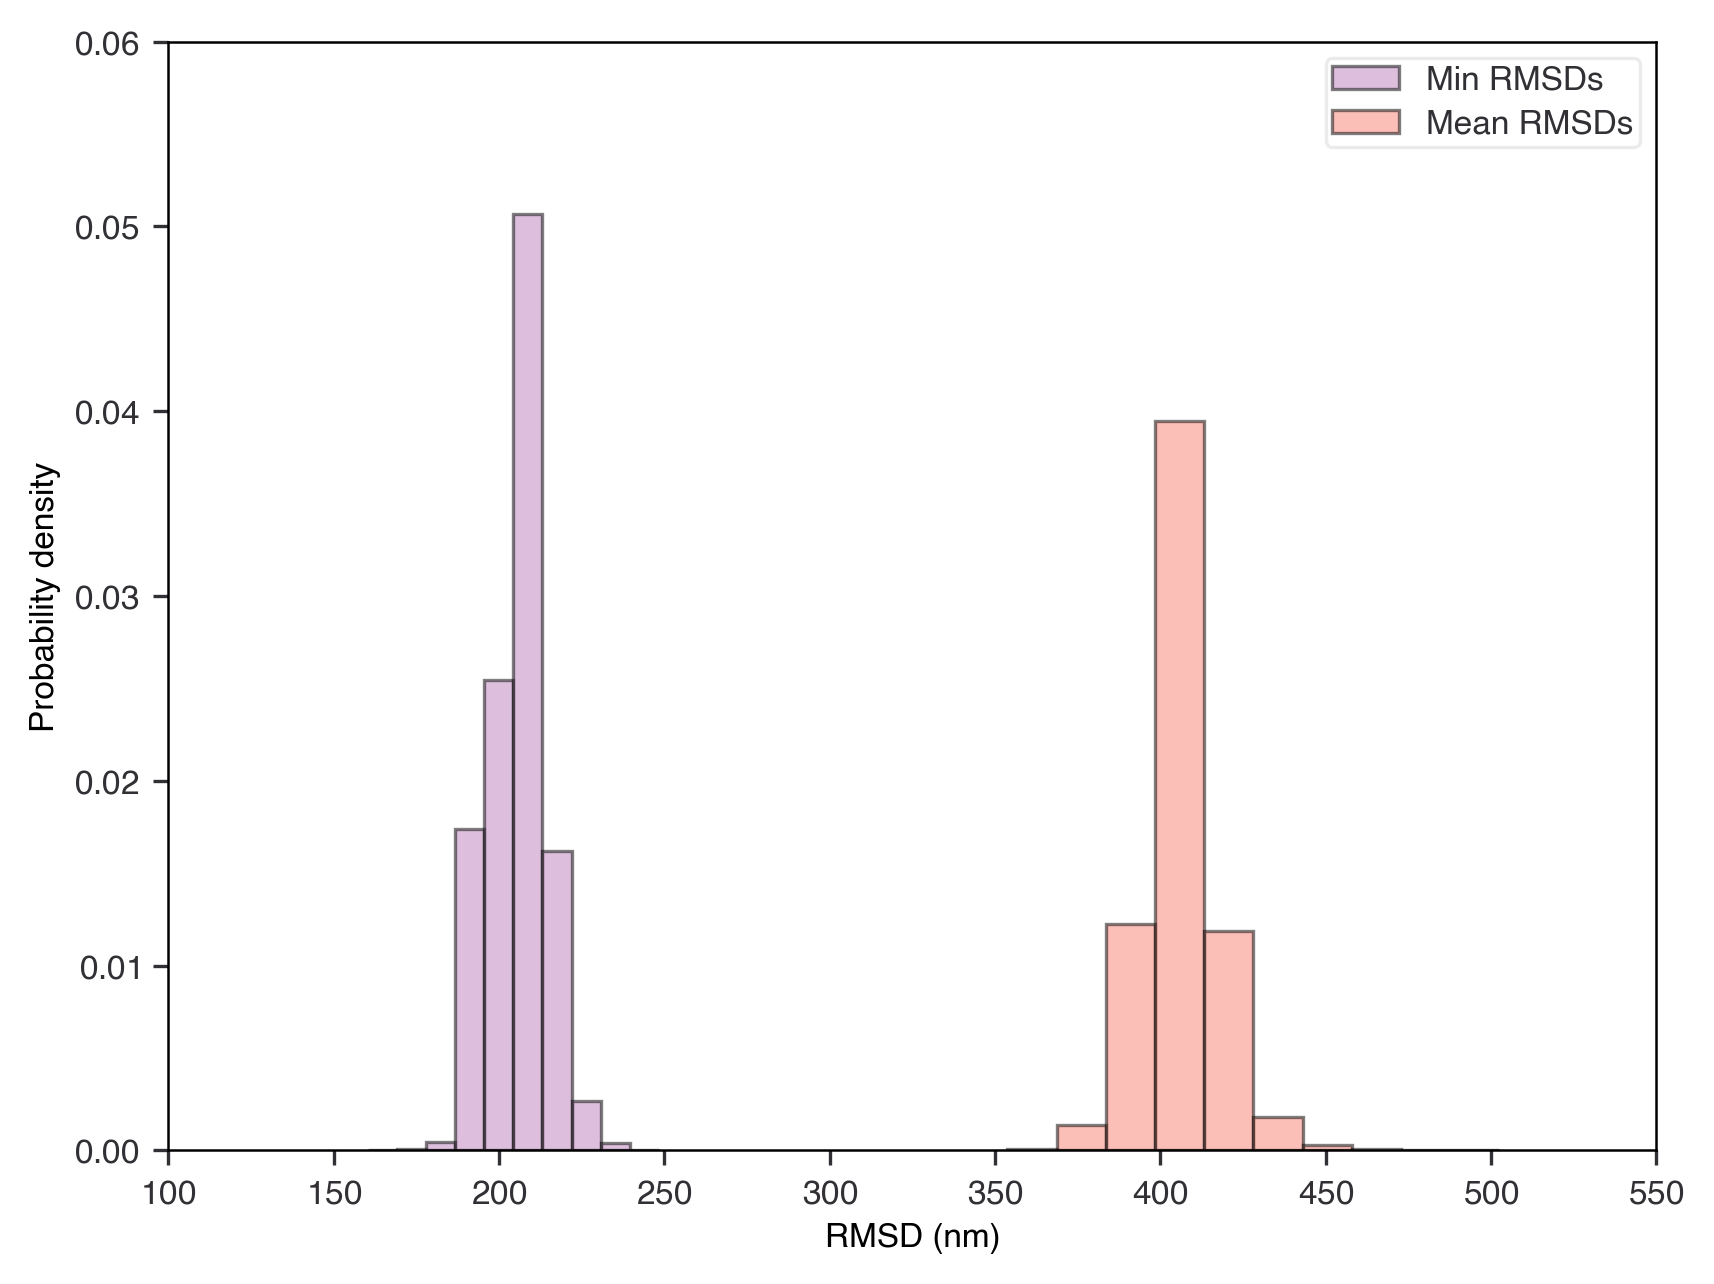

In [28]:
plt.hist(min_rmsds.flatten().cpu().numpy(),density=True,alpha=.5,label='Min RMSDs')
#plt.hist(random_rmsds.flatten().cpu().numpy(),density=True,alpha=.5,label='Random RMSDs')
plt.hist(mean_rmsds.flatten().cpu().numpy(),density=True,alpha=.5,label='Mean RMSDs')
plt.legend()
plt.xlabel('RMSD (nm)')
plt.ylabel('Probability density')

for i in range(100):
    temp_rmsds = tan_coords[100:].trajectory.clone().superpose(tan_coords[i]).rmsd(tan_coords[i])
    if i == 0:
        min_tan_rmsds = temp_rmsds
        mean_tan_rmsds = temp_rmsds

    else:
        min_tan_rmsds = torch.min(min_tan_rmsds, temp_rmsds)
        mean_tan_rmsds = mean_tan_rmsds + temp_rmsds

mean_tan_rmsds/= 100

plt.hist(min_tan_rmsds.flatten().cpu().numpy(),density=True,alpha=.5,label='Min RMSDs')
#plt.hist(random_rmsds.flatten().cpu().numpy(),density=True,alpha=.5,label='Random RMSDs')
plt.hist(mean_tan_rmsds.flatten().cpu().numpy(),density=True,alpha=.5,label='Mean RMSDs')
plt.legend()
plt.xlabel('RMSD (nm)')
plt.ylabel('Probability density')

Load homopolymer trajectory for comparison

In [29]:
import mdtraj
start = (500-64)//4
stop = start + 64
homo_coords = Coordinates(
    mdtraj.load(
        '/home/gridsan/gschuette/binz_group_shared/gkks/with_Amogh/40_Bead_systems/'+\
        'fully_connected_40_bead_PLM_only/LAMMPS_Files/run_e0.35/DUMP_FILE.dcd',
        top='/home/gridsan/gschuette/binz_group_shared/gkks/with_Amogh/40_Bead_systems/'+\
        'fully_connected_40_bead_PLM_only/LAMMPS_Files/data/data2.psf'
    ).xyz
)[:,start:stop,:]
homo_coords._values*= 1000 # to same scale as other polymers

Compute rg at all locations

In [30]:
gen_Rgs = compute_rg(gen_coords)
tan_Rgs = compute_rg(tan_coords)
homo_Rgs = compute_rg(homo_coords) 

Make the histogram

In [31]:
import numpy as np
def plot_hist(gen_data,tan_data,homo_data=None,nbins=25,fig=None,ax=None,alpha=0.5,xlim=None):

    # Convert to numpy to improve speed in plt 
    gen_data = gen_data.cpu().numpy()
    tan_data = tan_data.cpu().numpy()

    # Create consistent bins for eaach data type
    minn = min(gen_data.min(),tan_data.min())
    maxx = max(gen_data.max(),tan_data.max())
    delta = (maxx-minn)/nbins
    bins = np.arange(minn,maxx+delta/2,delta)

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(gen_data,alpha=alpha,bins=bins,label='ChromoGen',edgecolor='none',density=True)
    ax.hist(tan_data,alpha=alpha,bins=bins,label='Dip-C',edgecolor='none',density=True)
    if homo_data is not None:
        ax.hist(homo_data,alpha=alpha,bins=bins,label='Homopolymer',edgecolor='none',density=True)
    ax.set_ylabel('Probability density')

    # Make a square panel
    if xlim is not None:
        ax.set_xlim(xlim)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.set_aspect( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )

    return fig, ax

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'P', 'a', 'b', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 38, 39, 42, 51, 68, 69, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 35 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C',

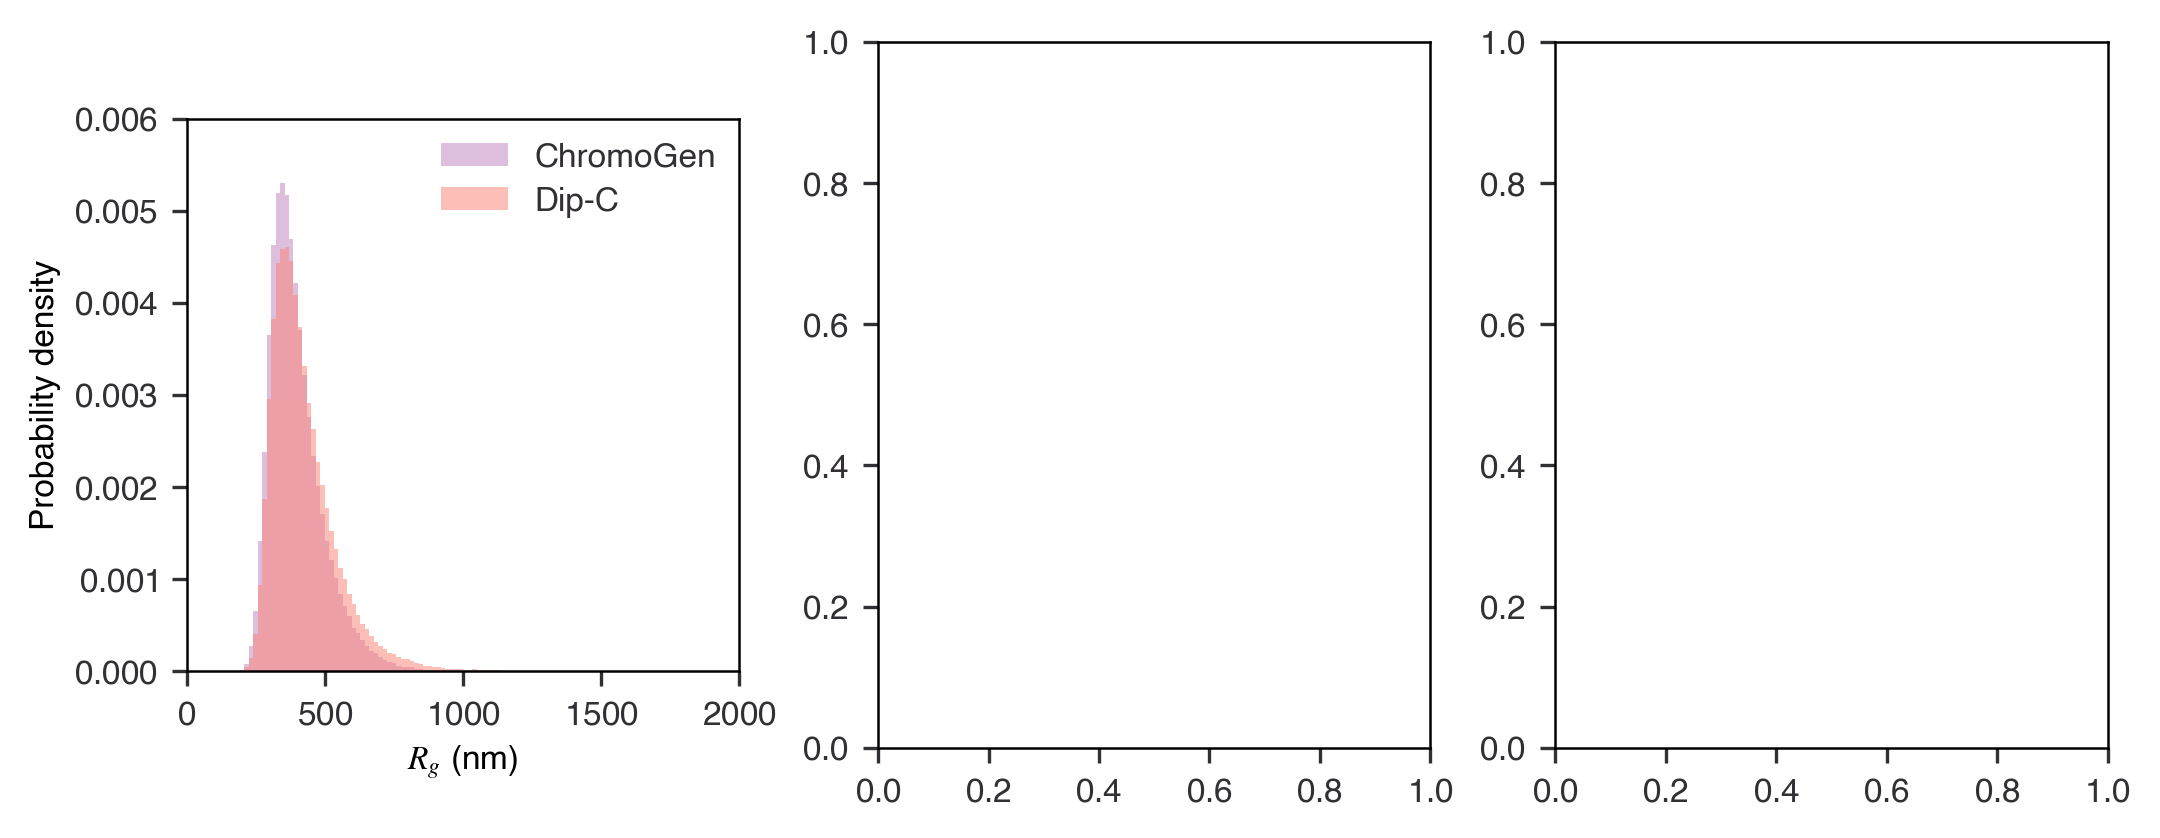

In [32]:
fig, axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(7.08661,6.69291/2.5)) # To ensure equal size as the other figure

# R_g histogram
ax = axes[0]
plot_hist(gen_Rgs,tan_Rgs,fig=fig,ax=ax,nbins=100)
ax.set_xlabel('$R_g$ (nm)')
ax.legend(framealpha=0,loc='upper right')#,fontsize='small')
fig.savefig(save_folder + 'r_g.pdf',transparent=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'H', 'P', 'a', 'b', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 38, 39, 42, 43, 51, 68, 69, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 36 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

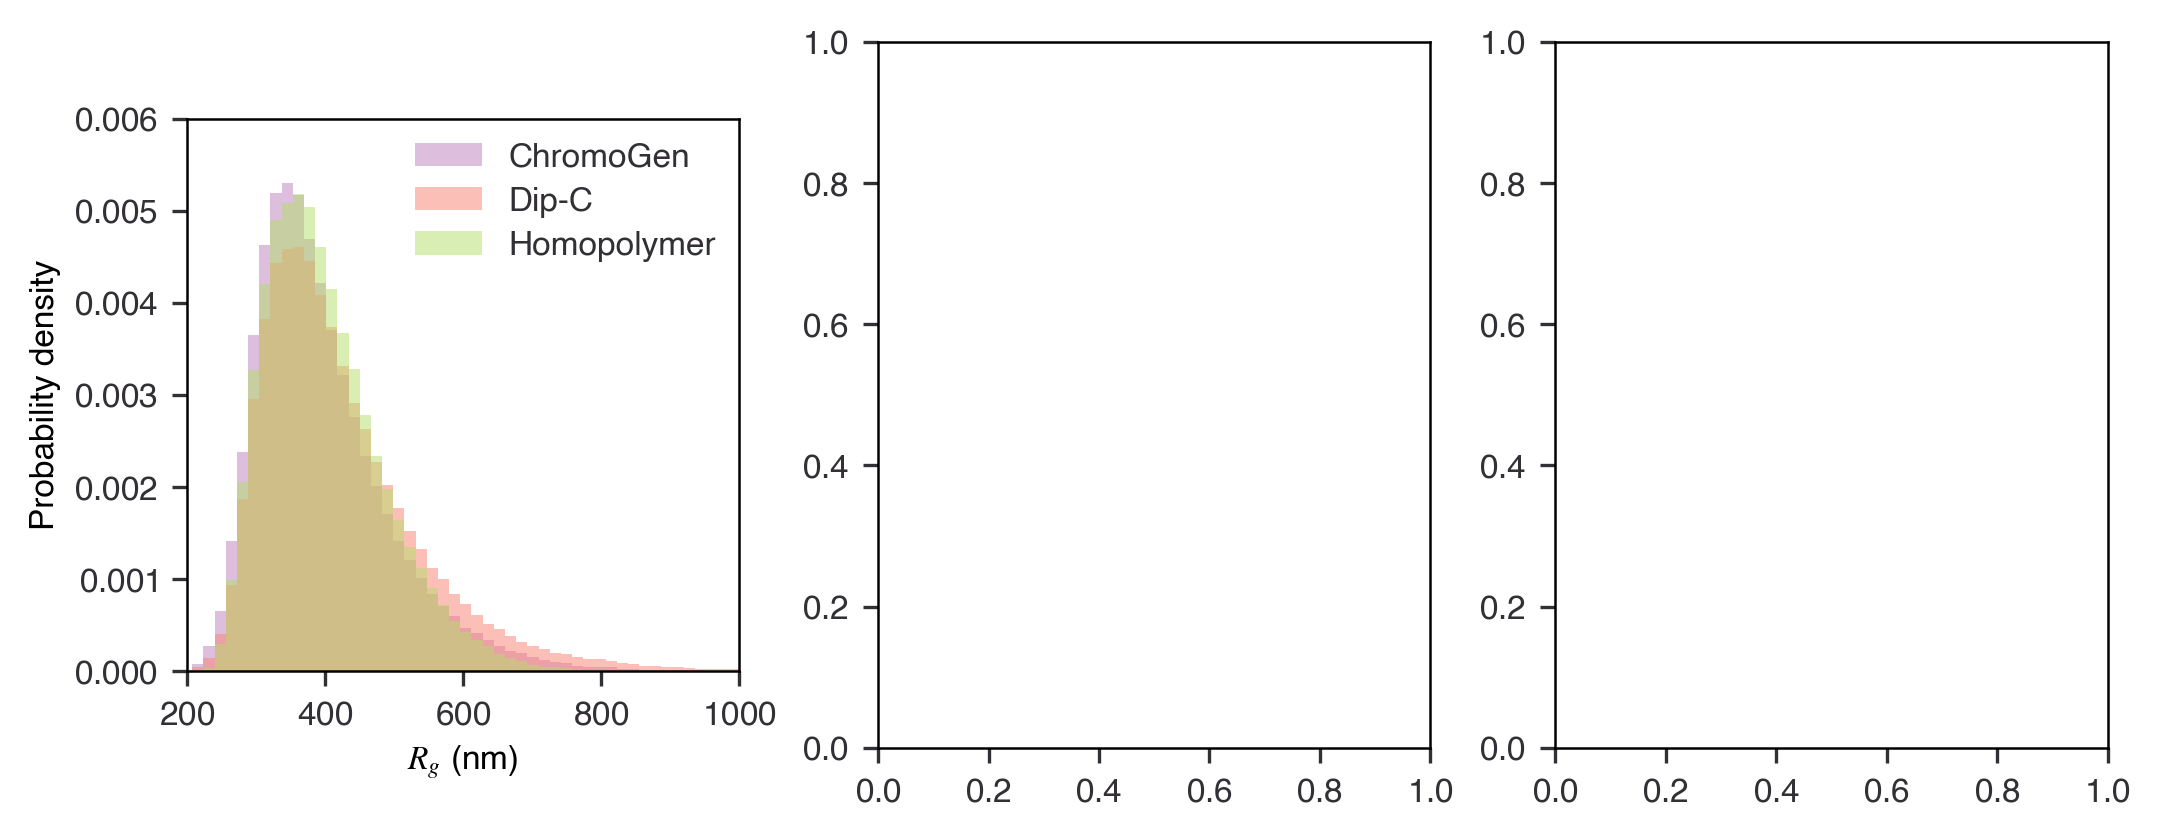

In [33]:
fig, axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(7.08661,6.69291/2.5)) # To ensure equal size as the other figure

# R_g histogram
ax = axes[0]
plot_hist(gen_Rgs,tan_Rgs,homo_Rgs,fig=fig,ax=ax,nbins=100,xlim=[200,1000])
ax.set_xlabel('$R_g$ (nm)')
ax.legend(framealpha=0,loc='upper right')#,fontsize='small')
fig.savefig(save_folder + 'r_g_with_homopolymer.pdf',transparent=True)

In [37]:
homo_dists = Distances(coords_to_dists(homo_coords.values,use_cuda=False))
homo_dists._values/= 100 # because the tan_dists, etc., are left in reduced form
KL_divs_homo = torch.tensor(
    [get_KL_div(homo_dists,tan_dists.float_(),separation) for separation in range(1,64)]
)

def compare_dist2(sep=1,corrected=corrected,tan=tan_dists,homo=homo_dists,fig=None,ax=None,nbins=100,**kwargs):

    assert sep > 0
    
    n = corrected.shape[-1]
    
    c = corrected.values[...,range(sep,n),range(n-sep)].flatten() * 100 # 100 to convert to nm
    t = tan.values[...,range(sep,n),range(n-sep)].flatten() * 100
    h = homo.values[...,range(sep,n),range(n-sep)].flatten() * 100

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if 'bins' in kwargs:
        bins = kwargs.pop('bins')
    else:
        minn = 0#min(c[c.isfinite()].min(),t[t.isfinite()].min())
        maxx = max(c[c.isfinite()].max(),t[t.isfinite()].max(),h[h.isfinite()].max())
        delta = (maxx-minn)/nbins
        bins = torch.arange(minn,maxx+delta,delta)
    
    c = c.cpu().numpy()
    t = t.cpu().numpy()
    h = h.cpu().numpy()

    #if sep==1:
    #    ax1 = ax.twinx()
    #else:
    #    ax1 = ax
    
    ax.hist(c,alpha=0.5,label='ChromoGen',density=True,bins=bins,edgecolor='none',**kwargs)
    ax.hist(t,alpha=0.5,label='Dip-C',density=True,bins=bins,edgecolor='none',**kwargs)
    #ax1.hist(h,alpha=0.5,label='Homopolymer',density=True,bins=bins,edgecolor='none',**kwargs)
    ax.hist(h,alpha=0.5,label='Homopolymer',density=True,bins=bins,edgecolor='none',**kwargs)
    
    ax.set_xlabel('Distance (nm)')# (Bond Lengths)')
    ax.set_ylabel('Probability density')
    title = 'Euclidean distance distribution for monomers separated by:\n'
    title+= f'{sep} bonds' if sep != 1 else f'{sep} bond'
    ax.set_title(title)

    if sep == 1:
        ax.set_ylim([0,.018])
    else:
        ax.set_ylim([0,ax.get_ylim()[1]])
    #ax.set_yticks(ax.get_ylim())
    
    ax.set_xlim([bins[0],bins[-1]])
    #ax.set_aspect(1.0/ax.get_data_ratio())#, adjustable='box')
    #if sep==1:
    #    ax1.set_ylim([0,ax1.get_ylim()[1]])
    #    ax1.set_aspect(1.0/ax1.get_data_ratio())
    #ax.set_aspect(1.0/ax.get_data_ratio())
    #if sep == 1:
    #    ax.set_ylim([0,.018])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
    
    ax.legend(framealpha=0,loc='upper right')#,fontsize='small')

    return fig, ax
    
#del homo_dists

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 49 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'G', 'H', 'K', 'L', 'M', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 36, 38, 39, 42, 43, 46, 47, 48, 51, 54, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 189

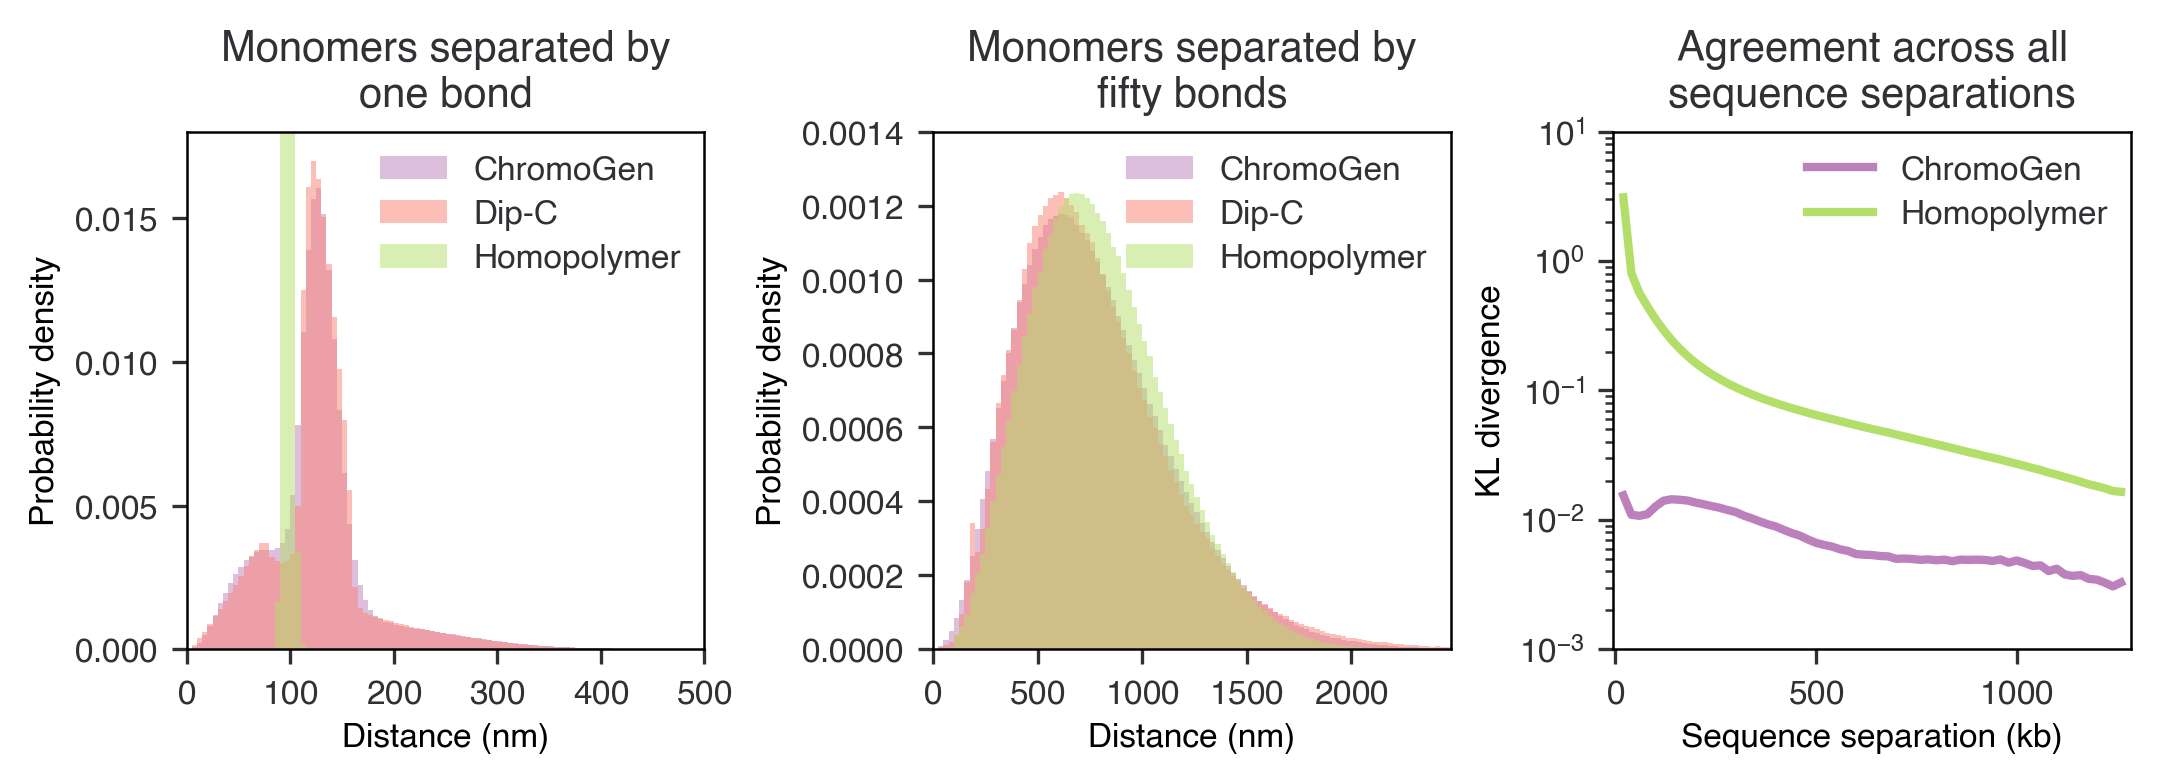

In [38]:
fig,axes = plt.subplots(nrows=1,ncols=3,layout='constrained',figsize=(7.08661,6.69291/2.5))

# Distance histograms
#compare_dist(1,bins=torch.arange(0,5.04,.05),fig=fig,ax=axes[0])
#compare_dist(50,bins=torch.arange(0,25,.25),fig=fig,ax=axes[1])
compare_dist2(1,bins=torch.arange(0,504,5.),fig=fig,ax=axes[0])
axes[0].set_title('Monomers separated by\none bond')
compare_dist2(50,bins=torch.arange(0,2500,25),fig=fig,ax=axes[1])
axes[1].set_title('Monomers separated by\nfifty bonds')

# Distance KL divergence plot
ax = axes[2]
ax.plot(torch.arange(1,64)*20,KL_divs,label='ChromoGen')
ax.plot(torch.arange(1,64)*20,KL_divs_homo,color='#b3de69',label='Homopolymer')
ax.legend(framealpha=0)
ax.set_yscale('log')
#ax.set_title('Agreement between scPredict and Dip-C distances')
ax.set_xlabel('Sequence separation (kb)')
ax.set_ylabel('KL divergence')
ax.set_xlim([-5,1285])
ylim = ax.get_ylim()
xlim = ax.get_xlim()
#ax.set_aspect( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )
ax.set_aspect( 2.5*(xlim[1]-xlim[0])/(ylim[1]-ylim[0]), adjustable='box')
ax.set_title('Agreement across all\nsequence separations')

fig.savefig(save_folder + 'distance_stats_with_homopolymer.pdf',transparent=True)

In [39]:
def get_pruned_data(gen_Rgs=gen_Rgs,tan_Rgs=tan_Rgs,num_bins=None):

    tan_Rgs = tan_Rgs.to(gen_Rgs.dtype)

    # Get the number of bins
    if num_bins is None:
        num_bins = int( 2 * ( min( gen_Rgs.numel(), tan_Rgs.numel() ) )**(1/3) )
    
    # Choose the bins
    maxx = max(gen_Rgs.max(),tan_Rgs.max())
    minn = min(gen_Rgs.min(),tan_Rgs.min())
    delta = (maxx-minn)/num_bins
    bins = torch.arange(minn,maxx+delta/2,delta,dtype=gen_Rgs.dtype)
    
    # Bin the data
    gen_probs = torch.histogram(gen_Rgs,bins).hist
    tan_probs = torch.histogram(tan_Rgs,bins).hist

    # Normalize to 1 (necessary since bins not necessarily equal to 1
    gen_probs/= gen_probs.sum()
    tan_probs/= tan_probs.sum()

    # Center bins for plotting purposes (making same length as the above data
    bins = (bins[1:] + bins[:-1])/2

    # Avoid NaN values by removing 0-probability bins
    idx = torch.where( (gen_probs!=0) & (tan_probs!=0) )[0]
    if len(idx) < len(gen_probs):
        gen_probs = gen_probs[idx]
        tan_probs = tan_probs[idx]
        bins = bins[idx]

    #print('KL-divergence',(tan_probs * (tan_probs.log() - gen_probs.log())).sum())
    print('KL-divergence',(gen_probs * (gen_probs.log() - tan_probs.log())).sum())
    
    return gen_probs,tan_probs, bins

    # Compute the KL-divergence with expectation probabilities from tan
    #return (tan_probs * (tan_probs.log() - gen_probs.log())).sum()
    return (gen_probs * (gen_probs.log() - tan_probs.log())).sum()

gen_probs,tan_probs,bin_centers = get_pruned_data()
_ = get_pruned_data(gen_Rgs=homo_Rgs,tan_Rgs=tan_Rgs,num_bins=None)

KL-divergence tensor(0.0281)
KL-divergence tensor(0.0398)


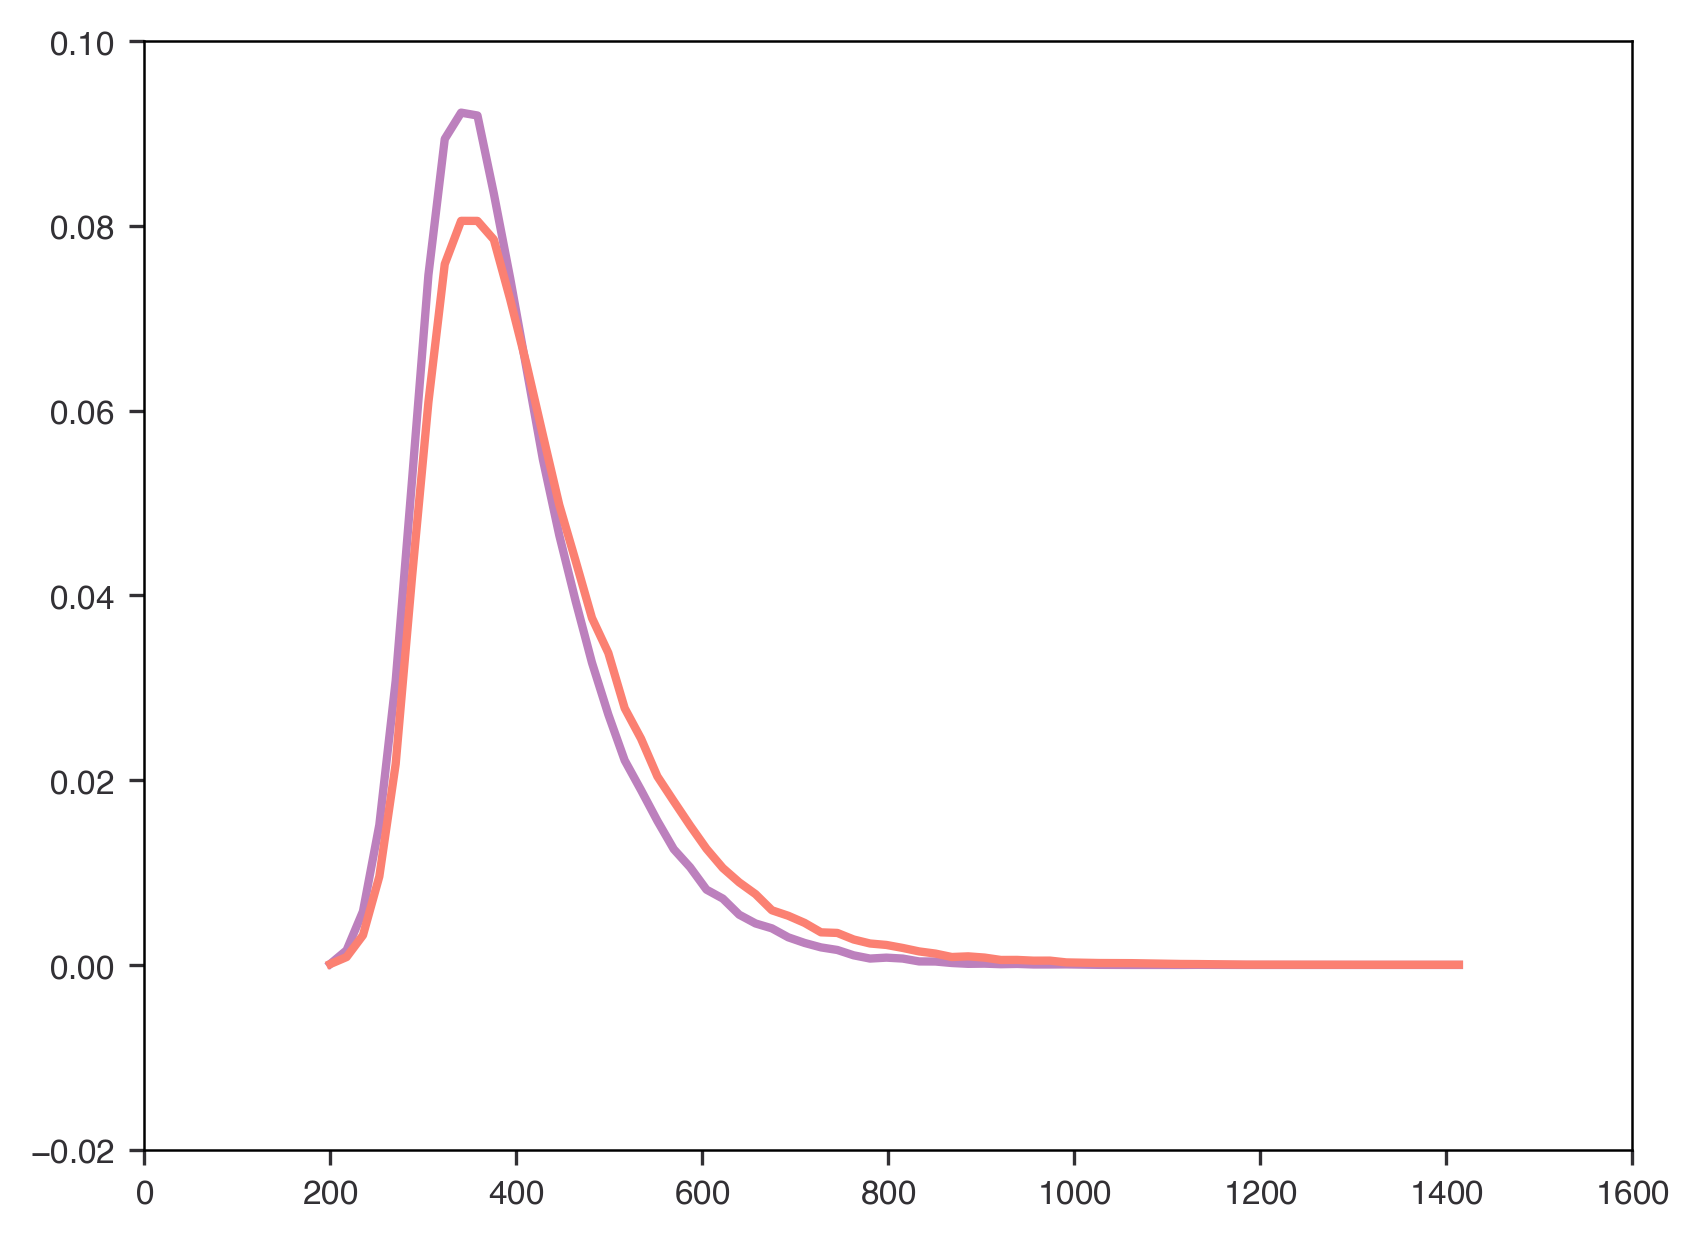

In [40]:
plt.plot(bin_centers,gen_probs)
plt.plot(bin_centers,tan_probs)

## SI Figures

In [41]:
def compare_dist(sep=1,corrected=corrected,uncorrected=uncorrected,nbins=100,**kwargs):

    assert sep > 0
    
    n = corrected.shape[-1]
    
    c = corrected.values[...,range(sep,n),range(n-sep)].flatten()
    u = uncorrected.values[...,range(sep,n),range(n-sep)].flatten()

    fig = plt.figure()
    ax = fig.add_subplot(111)

    if 'bins' in kwargs:
        bins = kwargs.pop('bins')
    else:
        minn = min(u[u.isfinite()].min(),c[c.isfinite()].min())
        maxx = max(u[u.isfinite()].max(),c[c.isfinite()].max())
        delta = (maxx-minn)/nbins
        bins = torch.arange(minn,maxx+delta,delta)
    
    c = c.cpu().numpy()
    u = u.cpu().numpy()

    ax.hist(u,alpha=0.5,label='Uncorrected',density=True,bins=bins,**kwargs)
    ax.hist(c,alpha=0.5,label='Corrected',density=True,bins=bins,**kwargs)

    ax.set_xlabel('Distance')# (Bond Lengths)')
    ax.set_ylabel('Probability Density')
    title = 'Euclidean distance distribution for monomers separated by:\n'
    title+= f'{sep} bonds' if sep != 1 else f'{sep} bond'
    ax.set_title(title)
    ax.set_xlim([bins[0],bins[-1]])

    ax.set_yticks(ax.get_ylim())
    
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.legend()

    return fig, ax
    

In [ ]:
compare_dist(1,bins=torch.arange(0,5.04,.05))
fig.savefig(save_folder+'SI_dist_hist_1.pdf',bbox_inches='tight')

In [ ]:
compare_dist(10,bins=torch.arange(0,17.51,.175))
fig.savefig(save_folder+'SI_dist_hist_10.pdf',bbox_inches='tight')

In [ ]:
compare_dist(50,bins=torch.arange(0,25,.25))
fig.savefig(save_folder+'SI_dist_hist_50.pdf',bbox_inches='tight')

#### Correlations

In [ ]:
def correlation_compare(contact,corrected_dists=corrected,tan_dists=uncorrected):#tan_dists):

    n = corrected_dists.shape[-1]
    bead_i,bead_j = contact

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    i,j = torch.triu_indices(n,n,1)
    correlations = torch.empty_like(corrected_dists.values[0,...].squeeze())
    corr_ref = corrected_dists.values[...,bead_i,bead_j].double().to(device).flatten()
    tan_ref = tan_dists.values[...,bead_i,bead_j].double().to(device).flatten()
    mask = tan_ref.isfinite()
    for bead_i1 in range(n-1):
        for bead_j1 in range(bead_i1+1,n):
            tan_compare = tan_dists.values[...,bead_i1,bead_j1].double().to(device).flatten()
            mask1 = mask & tan_compare.isfinite()
            correlations[bead_i1,bead_j1] = torch.corrcoef(
                torch.stack(
                    [
                        tan_ref[mask1],
                        tan_compare[mask1]
                        #tan_dists.values[...,bead_i1,bead_j1].double().to(device).flatten()
                    ],
                    dim = 0
                )
            )[0,1]

            correlations[bead_j1,bead_i1] = torch.corrcoef(
                torch.stack(
                    [
                        corr_ref, 
                        corrected_dists.values[...,bead_i1,bead_j1].double().to(device).flatten()
                    ],
                    dim = 0
                )
            )[0,1]#.to(dtype=correlations.dtype,device=correlations.device)

    i = torch.arange(correlations.shape[-1])
    correlations[i,i] = torch.nan
            
    return correlations

def plot_correlations(center_contact=(25,39)):
    
    correlations = correlation_compare(center_contact)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.matshow(correlations.cpu().numpy(),cmap='magma')
    cbar = fig.colorbar(im)
    
    cbar.set_label('Pearson Correlation Coefficient')
    ax.set_xlabel('Genomic Bin Index')
    ax.set_ylabel('Genomic Bin Index')
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.set_title(f'Correlation between the distance separating\nmonomers {center_contact[0]} and {center_contact[1]} and the distances\nseparating all other interaction pairs')

    n = ax.get_xlim()[-1]
    #ax.text(4,.005*n,'Dip-C Dataset',horizontalalignment='left',verticalalignment='top',
    #        color='white')
    #ax.text(n-4,.995*n-1,'Generated Data',horizontalalignment='right',verticalalignment='baseline',
    #        color='white')
    
    ax.text(4,.005*n,'Uncorrected',horizontalalignment='left',verticalalignment='top',
            color='white')
    
    ax.text(n-4,.995*n-1,'Corrected',horizontalalignment='right',verticalalignment='baseline',
            color='white')
    
    return fig, ax, im, cbar


In [ ]:
fig,*_=plot_correlations(center_contact=(25,39))
fig.savefig(save_folder+'SI_dist_corr_25_39.pdf',bbox_inches='tight')

In [ ]:
fig,*_=plot_correlations((16,48))
fig.savefig(save_folder+'SI_dist_corr_16_48.pdf',bbox_inches='tight')

In [ ]:
fig,*_=plot_correlations((9,55))
fig.savefig(save_folder+'SI_dist_corr_9_55.pdf',bbox_inches='tight')

#### Visualizing the Worst Matches

def compare_dists_map(idx,corrected=corrected,uncorrected=uncorrected):

    # Distance maps 
    
    n = uncorrected.num_beads
    i,j = torch.triu_indices(n,n,1)
    
    mat = corrected[idx].values.squeeze()
    mat[j,i] = uncorrected.values[idx,i,j]
   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.matshow(-mat.cpu(),cmap='coolwarm')
    cbar = fig.colorbar(im,label='Distance')

    cbar.ax.set_yticklabels([
        '$\\mathdefault{'+f'{abs(int(val))}'+'}$' for val in cbar.ax.get_yticks()
    ])
    ax.set_title('Corrected on top')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel('Genomic Index')
    ax.set_ylabel('Genomic Index')
    
    ax.text(.995*n-1,.005*n,'Corrected',horizontalalignment='right',verticalalignment='top',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    ax.text(.005*n,.995*n-1,'Uncorrected',horizontalalignment='left',verticalalignment='baseline',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    
    return fig, ax, im, cbar

def compare_dists_scatter(idxs,corrected=corrected,uncorrected=uncorrected):

    # Scatter Plot
    
    if type(idxs) != list:
        idxs = [idxs]

    n = uncorrected.num_beads
    i,j = torch.triu_indices(n,n,1)

    mins = []
    maxes= []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for k,idx in enumerate(idxs):
    
        corr = corrected.values[idx,i,j]
        uncorr = uncorrected.values[idx,i,j]
        mins.append(max(corr.min(),uncorr.min()))
        maxes.append(min(corr.max(),uncorr.max()))
    
        if len(idxs) == 1:
            ax.plot(uncorr,corr,'.',label='Data')
        elif k == 0:
            ax.plot(uncorr,corr,'.',alpha=.5,label='By mean absolute deviation')
        else:
            ax.plot(uncorr,corr,'.',alpha=.5,label='By mean square deviation')

    min_max = [min(mins),max(maxes)]
    ax.plot(min_max,min_max,label='Perfect Match')
    #lims = [0,max(ax.get_ylim()[-1],ax.get_xlim()[-1])]
    #ax.set_xlim(lims)
    #ax.set_ylim(lims)
    #ax.set_aspect(1.0, adjustable='box')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.legend()
    ax.set_xlabel('Uncorrected Distances')
    ax.set_ylabel('Corrected Distances')

    return fig, ax


In [ ]:
def compare_dists_map(idx,corrected=corrected,uncorrected=uncorrected,fig=None,ax=None):

    # Distance maps 
    
    n = uncorrected.num_beads
    i,j = torch.triu_indices(n,n,1)
    
    mat = corrected[idx].values.squeeze()
    mat[j,i] = uncorrected.values[idx,i,j]

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    _,_,im,cbar = corrected[idx].plot_with(uncorrected[idx],fig=fig,ax=ax,cbar_orientation='horizontal')
    cbar.set_label('Distance (nm)')

    #cbar.ax.set_yticklabels([
    #    '$\\mathdefault{'+f'{abs(int(val))}'+'}$' for val in cbar.ax.get_yticks()
    #])
    #ax.set_title('Corrected on top')

    #ax.set_xticks([])
    #ax.set_yticks([])

    #ax.set_xlabel('Genomic Index')
    #ax.set_ylabel('Genomic Index')
    
    ax.text(.995*n-1,.005*n,'Corrected',horizontalalignment='right',verticalalignment='top',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],size='x-small')

    ax.text(.005*n,.995*n-1,'Uncorrected',horizontalalignment='left',verticalalignment='baseline',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],size='x-small')
    
    return fig, ax, im, cbar

def compare_dists_scatter(idxs,corrected=corrected,uncorrected=uncorrected,fig=None,ax=None):

    # Scatter Plot
    
    if type(idxs) != list:
        idxs = [idxs]

    n = uncorrected.num_beads
    i,j = torch.triu_indices(n,n,1)

    mins = []
    maxes= []
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    for k,idx in enumerate(idxs):
    
        corr = corrected.values[idx,i,j]
        uncorr = uncorrected.values[idx,i,j]
        mins.append(max(corr.min(),uncorr.min()))
        maxes.append(min(corr.max(),uncorr.max()))
    
        if len(idxs) == 1:
            ax.plot(uncorr,corr,'.',label='Data')
        elif k == 0:
            ax.plot(uncorr,corr,'.',alpha=.5,label='By mean absolute deviation')
        else:
            ax.plot(uncorr,corr,'.',alpha=.5,label='By mean square deviation')

    min_max = [min(mins),max(maxes)]
    ax.plot(min_max,min_max,label='Perfect Match')
    #lims = [0,max(ax.get_ylim()[-1],ax.get_xlim()[-1])]
    #ax.set_xlim(lims)
    #ax.set_ylim(lims)
    #ax.set_aspect(1.0, adjustable='box')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.legend(framealpha=1)
    ax.set_xlabel('Uncorrected Distances')
    ax.set_ylabel('Corrected Distances')

    return fig, ax


differences = (uncorrected.values - corrected.values).abs()
diff_abs = differences.mean((-2,-1))
diff_sq = differences.square().mean((-2,-1))
del differences

titles = [
    'Worst reconstruction',
    'Second-worst reconstruction',
    'Third-worst reconstruction',
    'Fourth-worst reconstruction',
]

for i in range(4):

    title = titles[i]

    # Select the regions to plot
    by_abs = diff_abs[diff_abs.isfinite()]
    by_sq = diff_sq[diff_sq.isfinite()]
    worst_by_abs = torch.where(diff_abs == by_abs.max())[0]
    worst_by_sq = torch.where(diff_sq == by_sq.max())[0]

    # Plot the distance maps
    fig,ax,im,cbar = compare_dists_map(worst_by_abs)
    ax.set_title(title)#+', as determined by\nmean absolute deviation\nCorrected on top')
    fig.savefig(save_folder+f'SI_{i}_worst_absolute.pdf',bbox_inches='tight')
    
    fig,ax,im,cbar = compare_dists_map(worst_by_sq)
    ax.set_title(title)#+', as determined by\nmean square deviation\nCorrected on top')
    fig.savefig(save_folder+f'SI_{i}_worst_square.pdf',bbox_inches='tight')

    # Make the scatter plot
    fig, ax = compare_dists_scatter([worst_by_abs,worst_by_sq])
    ax.set_title(title+'s')
    fig.savefig(save_folder+f'SI_{i}_worst_scatter.pdf',bbox_inches='tight')

    # Prepare to plot the next-worst data
    diff_abs[worst_by_abs] = torch.nan
    diff_sq[worst_by_sq] = torch.nan
    

Plot worst matches by 

In [ ]:
#corrected = Distances(corrected.values*100)
#uncorrected = Distances(uncorrected.values*100)

In [ ]:
differences = (uncorrected.values - corrected.values).abs()
diff_abs = differences.mean((-2,-1))
diff_sq = differences.square().mean((-2,-1))
del differences

titles = [
    'Worst reconstructions',
    'Second-worst reconstructions',
    'Third-worst reconstructions',
    'Fourth-worst reconstructions',
]

for i in range(1):#4):

    title = titles[i]

    # Select the regions to plot
    by_abs = diff_abs[diff_abs.isfinite()]
    by_sq = diff_sq[diff_sq.isfinite()]
    worst_by_abs = torch.where(diff_abs == by_abs.max())[0]
    worst_by_sq = torch.where(diff_sq == by_sq.max())[0]

    #fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(7.08*.65,6.692*.32),layout="constrained")
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(7.08*.65,6.692*.27),layout="constrained")
    
    # Plot the distance maps
    fig,ax,im,cbar = compare_dists_map(worst_by_abs,fig=fig,ax=ax1)
    #ax.set_title('By mean\nabsolute deviation')
    #ax.set_title(title)#+', as determined by\nmean absolute deviation\nCorrected on top')
    #fig.savefig(save_folder+f'SI_{i}_worst_absolute.pdf',bbox_inches='tight')
    
    fig,ax,im,cbar = compare_dists_map(worst_by_sq,fig=fig,ax=ax2)
    #ax.set_title('By mean-square\ndeviation')
    #ax.set_title(title)#+', as determined by\nmean square deviation\nCorrected on top')
    #fig.savefig(save_folder+f'SI_{i}_worst_square.pdf',bbox_inches='tight')

    # Make the scatter plot
    fig, ax = compare_dists_scatter([worst_by_abs,worst_by_sq],fig=fig,ax=ax3)
    #ax.set_title(title)#+'s')
    fig.suptitle(title)
    #fig.savefig(save_folder+f'SI_{i}_worst_scatter.pdf',bbox_inches='tight')

    # Prepare to plot the next-worst data
    diff_abs[worst_by_abs] = torch.nan
    diff_sq[worst_by_sq] = torch.nan
    

In [ ]:
asdf

In [ ]:
titles = [
    'Corrected sample with the worst agreement with starting structure',
    'Corrected sample with the second-worst agreement with starting structure',
    'Corrected sample with the third-worst agreement with starting structure',
    'Corrected sample with the fourth-worst agreement with starting structure',
]

n = corrected.num_beads
i,j = torch.triu_indices(n,n,1)
for i in range(4):

    title = titles[i]
    
    # Get the next-worst index
    worst_match_idx = torch.where( differences == dd.max() )[0]
    

    # Plot the results
    fig,ax,im,cbar = compare_dists_map(worst_match_idx)
    fig2,ax2 = compare_dists_scatter(worst_match_idx)

    # Prepare for the next cycle
    differences[worst_match_idx] = torch.nan
    dd = differences[differences.isfinite()]
    

fig, ax, im, cmap = corrected[worst_match_idx].plot_with(uncorrected[worst_match_idx])
fig, ax, im, cmap = corrected[best_match_idx].plot_with(corrected[best_match_idx])


idx = torch.where(uncorrected.values.isfinite().all(-1).all(-1))[0][:100]
n = corrected.num_beads
i,j = torch.triu_indices(n,n,1)

fig = plt.figure()
ax = fig.add_subplot(111)
x = torch.cat(
    [
        uncorrected.values[ii,i,j].cpu() for ii in idx
    ]
)
y = torch.cat(
    [
        corrected.values[ii,i,j].cpu() for ii in idx
    ]
)
min_max = [max(x.min(),y.min()),min(x.max(),y.max())]

ax.plot(min_max,min_max,label='Perfect match')
ax.plot(x,y,'.',label='Data')
ax.set_xlabel('Uncorrected Distances')
ax.set_ylabel('Corrected Distances')
ax.set_title('Distance shift from correcting distance maps')
